# PushT dataset exploratory analysis
Exploration of `pusht_data.npz` produced by `save_pusht_dataset.py`. Arrays include actions (2 dims), states (7 dims), proprio (4 dims), and episode/step indices. Plots use sub-sampling to stay responsive while keeping distributions representative.


In [38]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

data_path = Path("pusht_data.npz")
npz = np.load(data_path)

actions = npz["actions"]
states = npz["states"]
proprio = npz["proprio"]
episode_indices = npz["episode_indices"]
step_indices = npz["step_indices"]

num_steps = len(actions)
num_episodes = int(episode_indices.max()) + 1 if episode_indices.size else 0

print(f"Loaded {data_path} with {num_steps:,} steps across {num_episodes} episodes")
for name, arr in [
    ("actions", actions),
    ("states", states),
    ("proprio", proprio),
    ("episode_indices", episode_indices),
    ("step_indices", step_indices),
]:
    print(f"{name:16s} shape={arr.shape} dtype={arr.dtype}")

rng = np.random.default_rng(0)
analysis_sample_idx = rng.choice(num_steps, size=min(num_steps, 200000), replace=False)


Loaded pusht_data.npz with 2,336,736 steps across 18685 episodes
actions          shape=(2336736, 2) dtype=float32
states           shape=(2336736, 7) dtype=float32
proprio          shape=(2336736, 4) dtype=float32
episode_indices  shape=(2336736,) dtype=int64
step_indices     shape=(2336736,) dtype=int64


Quick peek at the first few rows to confirm indexing and typical values.

In [39]:
preview_df = pd.DataFrame({
    "episode_idx": episode_indices[:5],
    "step_idx": step_indices[:5],
    "action_0": actions[:5, 0],
    "action_1": actions[:5, 1],
})

for i in range(states.shape[1]):
    preview_df[f"state_{i}"] = states[:5, i]

for i in range(proprio.shape[1]):
    preview_df[f"proprio_{i}"] = proprio[:5, i]

preview_df


episode_idx  step_idx  action_0  action_1     state_0     state_1  \
0            0         0  0.140000 -0.250000  423.000000  182.000000   
1            0         1  0.058606 -0.086082  427.139404  174.608200   
2            0         2 -0.024401  0.037367  430.440063  169.263275   
3            0         3 -0.103647  0.045776  430.364655  169.422440   
4            0         4 -0.510226 -0.042006  427.022644  171.200562   

      state_2     state_3  state_4    state_5    state_6   proprio_0  \
0  192.670609  335.156769   2.9477   0.000000   0.000000  423.000000   
1  192.670609  335.156769   2.9477  52.380672 -93.536911  427.139404   
2  192.670609  335.156769   2.9477  21.584066 -31.594496  430.440063   
3  192.670609  335.156769   2.9477  -9.270866  14.187885  430.364655   
4  192.670609  335.156769   2.9477 -38.718369  17.033871  427.022644   

    proprio_1  proprio_2  proprio_3  
0  182.000000   0.000000   0.000000  
1  174.608200  52.380672 -93.536911  
2  169.263275  21.584066 -31.594496  
3  169.422440  -9.270866  14.187885  
4  171.200562 -38.718369  17.033871

Episode length distribution and summary statistics.

count    18685.000000
mean       125.059459
std         36.363736
min         49.000000
25%         99.000000
50%        123.000000
75%        148.000000
90%        171.000000
99%        229.000000
max        246.000000
Name: episode_length, dtype: float64

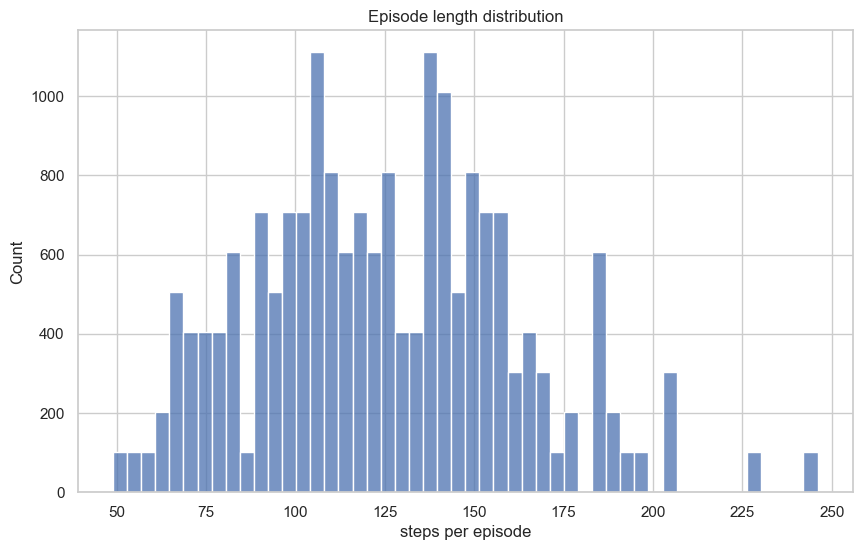

In [40]:
episode_lengths = np.bincount(episode_indices, minlength=num_episodes)
lengths = pd.Series(episode_lengths, name="episode_length")

display(lengths.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]))

fig, ax = plt.subplots()
sns.histplot(lengths, bins=50, ax=ax)
ax.set_title("Episode length distribution")
ax.set_xlabel("steps per episode")
plt.show()


Action distributions and correlation on a manageable sample.

action_0       action_1
count  200000.000000  200000.000000
mean       -0.008408       0.006965
std         0.208301       0.206072
min        -1.328254      -1.372726
25%        -0.121822      -0.108718
50%        -0.008112       0.002134
75%         0.097521       0.126843
max         1.809306       1.460040

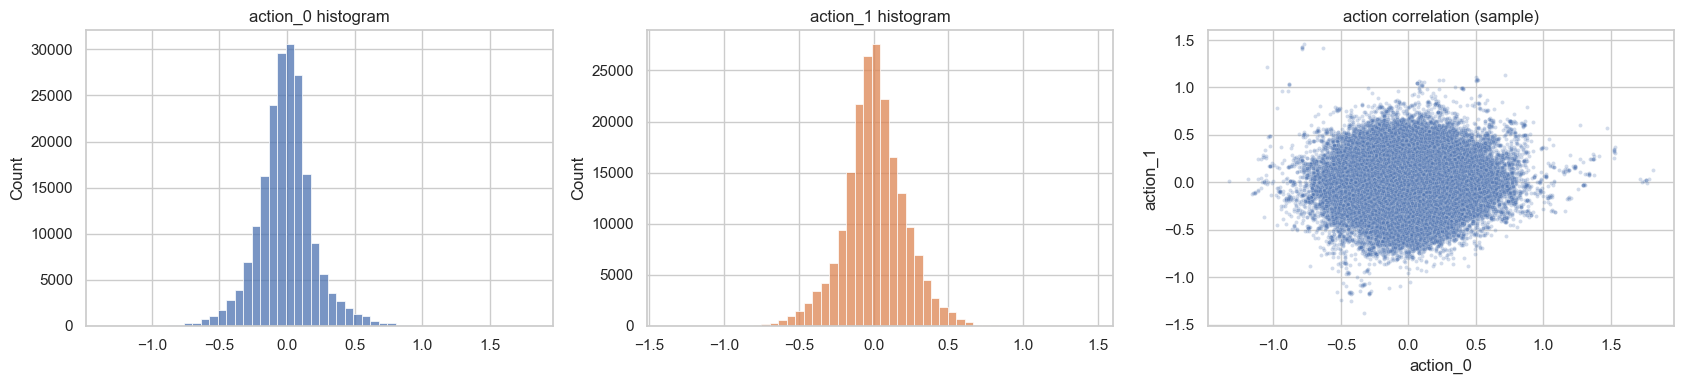

In [41]:
action_sample = actions[analysis_sample_idx]
action_df = pd.DataFrame(action_sample, columns=["action_0", "action_1"])

display(action_df.describe())

fig, axes = plt.subplots(1, 3, figsize=(17, 4))
sns.histplot(action_sample[:, 0], bins=50, ax=axes[0], color="C0")
axes[0].set_title("action_0 histogram")
sns.histplot(action_sample[:, 1], bins=50, ax=axes[1], color="C1")
axes[1].set_title("action_1 histogram")
sns.scatterplot(x=action_sample[:, 0], y=action_sample[:, 1], ax=axes[2], s=8, alpha=0.25)
axes[2].set_title("action correlation (sample)")
axes[2].set_xlabel("action_0")
axes[2].set_ylabel("action_1")

plt.tight_layout()
plt.show()


X-Y trajectory visualization: plot individual episode trajectories and compute mean trajectory across all episodes.


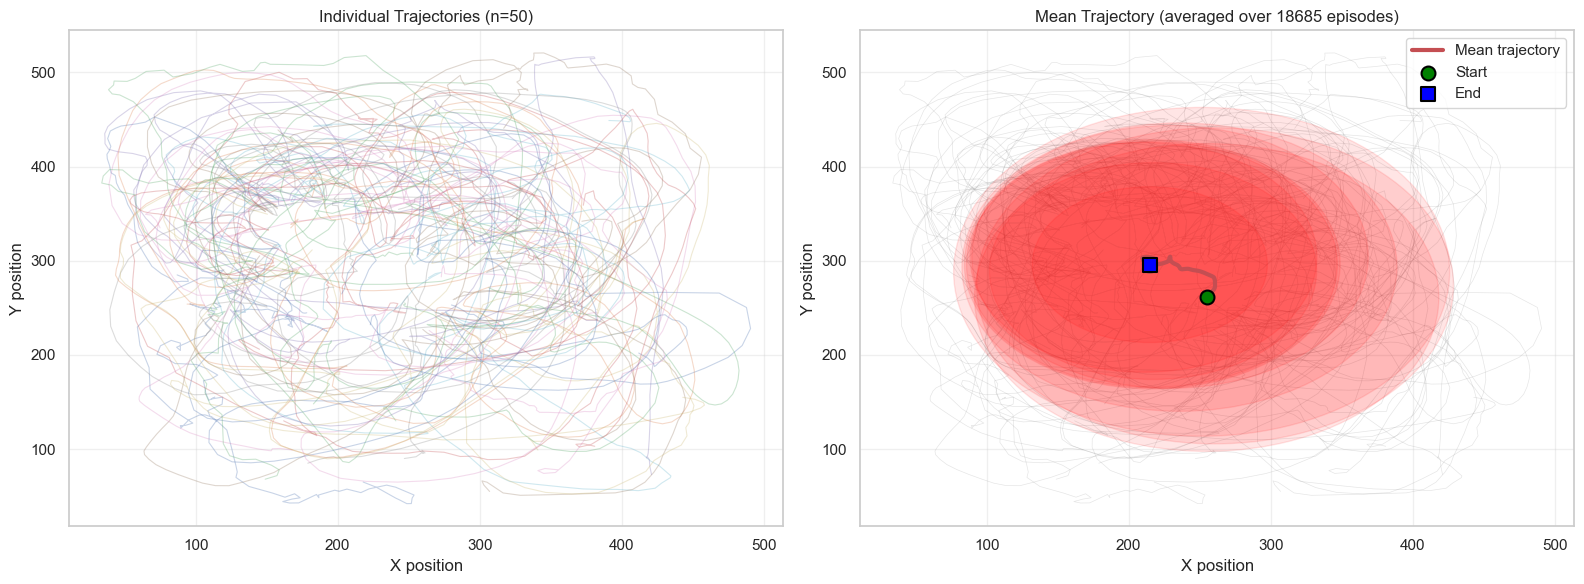

Mean trajectory computed over 18685 episodes
Episode length range: 49 to 246 steps
Mean episode length: 125.1 steps


In [42]:
# Extract x and y coordinates (assuming first 2 state dimensions are x, y)
x_coords = states[:, 0]
y_coords = states[:, 1]

# Sample episodes for visualization (use fewer episodes for cleaner plot)
num_episodes_to_plot = min(50, num_episodes)
sampled_episodes = rng.choice(num_episodes, size=num_episodes_to_plot, replace=False)

# Collect all trajectories
all_trajectories_x = []
all_trajectories_y = []

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot individual trajectories
for ep_idx in sampled_episodes:
    mask = episode_indices == ep_idx
    ep_x = x_coords[mask]
    ep_y = y_coords[mask]
    
    axes[0].plot(ep_x, ep_y, alpha=0.3, linewidth=0.8)
    all_trajectories_x.append(ep_x)
    all_trajectories_y.append(ep_y)

axes[0].set_title(f"Individual Trajectories (n={num_episodes_to_plot})")
axes[0].set_xlabel("X position")
axes[0].set_ylabel("Y position")
axes[0].grid(True, alpha=0.3)

# Compute mean trajectory across all episodes
# Find the maximum episode length to determine interpolation grid
max_ep_length = episode_lengths.max()
time_grid = np.arange(max_ep_length)

# Interpolate all trajectories to common time grid
interpolated_x = []
interpolated_y = []

for ep_idx in range(num_episodes):
    mask = episode_indices == ep_idx
    ep_x = x_coords[mask]
    ep_y = y_coords[mask]
    
    if len(ep_x) > 1:  # Need at least 2 points for interpolation
        t_original = np.arange(len(ep_x))
        t_new = np.linspace(0, len(ep_x) - 1, max_ep_length)
        
        x_interp = np.interp(t_new, t_original, ep_x)
        y_interp = np.interp(t_new, t_original, ep_y)
        
        interpolated_x.append(x_interp)
        interpolated_y.append(y_interp)

# Compute mean and std
mean_x = np.mean(interpolated_x, axis=0)
mean_y = np.mean(interpolated_y, axis=0)
std_x = np.std(interpolated_x, axis=0)
std_y = np.std(interpolated_y, axis=0)

# Plot individual trajectories again on second plot
for ep_idx in sampled_episodes:
    mask = episode_indices == ep_idx
    ep_x = x_coords[mask]
    ep_y = y_coords[mask]
    axes[1].plot(ep_x, ep_y, alpha=0.2, linewidth=0.5, color='gray')

# Plot mean trajectory with confidence band
axes[1].plot(mean_x, mean_y, 'r-', linewidth=3, label='Mean trajectory', zorder=10)
axes[1].scatter(mean_x[0], mean_y[0], c='green', s=100, marker='o', 
               label='Start', zorder=11, edgecolors='black', linewidth=1.5)
axes[1].scatter(mean_x[-1], mean_y[-1], c='blue', s=100, marker='s', 
               label='End', zorder=11, edgecolors='black', linewidth=1.5)

# Add confidence ellipses at key points
n_ellipses = 10
ellipse_indices = np.linspace(0, len(mean_x)-1, n_ellipses, dtype=int)
for idx in ellipse_indices:
    circle = plt.Circle((mean_x[idx], mean_y[idx]), 
                        radius=np.sqrt(std_x[idx]**2 + std_y[idx]**2),
                        color='red', alpha=0.1, zorder=5)
    axes[1].add_patch(circle)

axes[1].set_title(f"Mean Trajectory (averaged over {num_episodes} episodes)")
axes[1].set_xlabel("X position")
axes[1].set_ylabel("Y position")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean trajectory computed over {num_episodes} episodes")
print(f"Episode length range: {episode_lengths.min()} to {episode_lengths.max()} steps")
print(f"Mean episode length: {episode_lengths.mean():.1f} steps")


X and Y positions over time: plot trajectories as time series with mean trajectories.


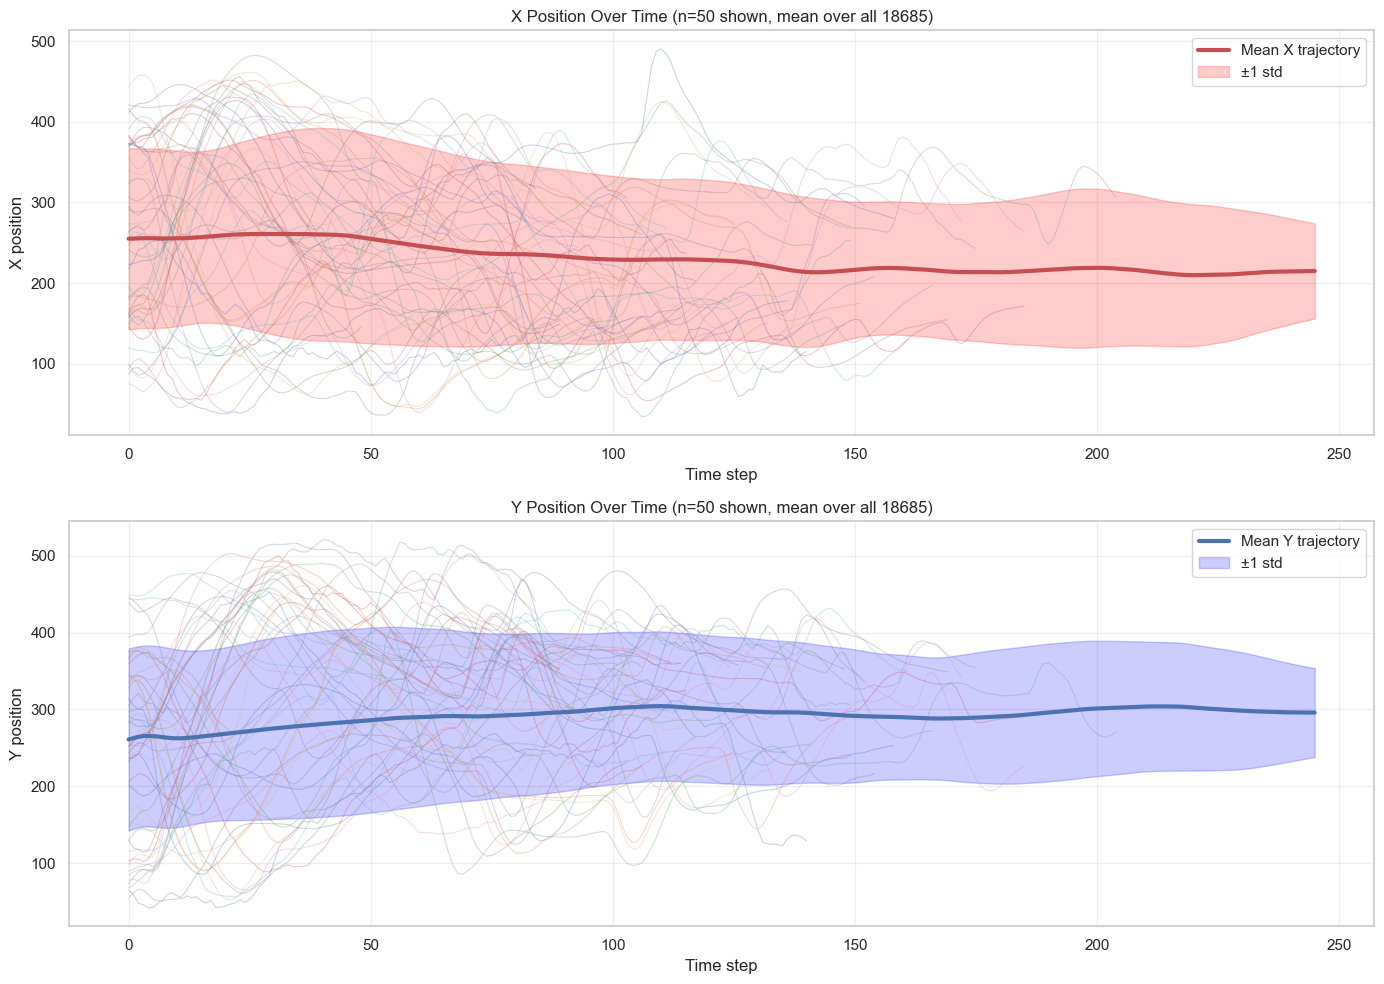

In [43]:
# Plot x and y positions over time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Use the same sampled episodes for consistency
for ep_idx in sampled_episodes:
    mask = episode_indices == ep_idx
    ep_x = x_coords[mask]
    ep_y = y_coords[mask]
    ep_steps = step_indices[mask]
    
    axes[0].plot(ep_steps, ep_x, alpha=0.3, linewidth=0.8)
    axes[1].plot(ep_steps, ep_y, alpha=0.3, linewidth=0.8)

# Plot mean trajectories over time
time_steps = np.arange(max_ep_length)
axes[0].plot(time_steps, mean_x, 'r-', linewidth=3, label='Mean X trajectory')
axes[0].fill_between(time_steps, mean_x - std_x, mean_x + std_x, 
                     color='red', alpha=0.2, label='±1 std')

axes[1].plot(time_steps, mean_y, 'b-', linewidth=3, label='Mean Y trajectory')
axes[1].fill_between(time_steps, mean_y - std_y, mean_y + std_y, 
                     color='blue', alpha=0.2, label='±1 std')

axes[0].set_title(f"X Position Over Time (n={num_episodes_to_plot} shown, mean over all {num_episodes})")
axes[0].set_xlabel("Time step")
axes[0].set_ylabel("X position")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title(f"Y Position Over Time (n={num_episodes_to_plot} shown, mean over all {num_episodes})")
axes[1].set_xlabel("Time step")
axes[1].set_ylabel("Y position")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Action trajectory visualization: plot relative movement actions (action_0, action_1) as trajectories.


In [44]:
# Extract action dimensions (relative movements in x and y)
action_x = actions[:, 0]
action_y = actions[:, 1]

# Collect action trajectories and compute cumulative movements
all_action_trajectories_x = []
all_action_trajectories_y = []
all_cumulative_x = []
all_cumulative_y = []

# Interpolate all action trajectories to common time grid
interpolated_action_x = []
interpolated_action_y = []
interpolated_cumulative_x = []
interpolated_cumulative_y = []

for ep_idx in range(num_episodes):
    mask = episode_indices == ep_idx
    ep_action_x = action_x[mask]
    ep_action_y = action_y[mask]
    
    # Compute cumulative actions (trajectory in action space)
    ep_cumulative_x = np.cumsum(ep_action_x)
    ep_cumulative_y = np.cumsum(ep_action_y)
    
    if len(ep_action_x) > 1:  # Need at least 2 points for interpolation
        t_original = np.arange(len(ep_action_x))
        t_new = np.linspace(0, len(ep_action_x) - 1, max_ep_length)
        
        # Interpolate raw actions
        action_x_interp = np.interp(t_new, t_original, ep_action_x)
        action_y_interp = np.interp(t_new, t_original, ep_action_y)
        
        # Interpolate cumulative actions
        cumulative_x_interp = np.interp(t_new, t_original, ep_cumulative_x)
        cumulative_y_interp = np.interp(t_new, t_original, ep_cumulative_y)
        
        interpolated_action_x.append(action_x_interp)
        interpolated_action_y.append(action_y_interp)
        interpolated_cumulative_x.append(cumulative_x_interp)
        interpolated_cumulative_y.append(cumulative_y_interp)

# Compute mean and std for actions
mean_action_x = np.mean(interpolated_action_x, axis=0)
mean_action_y = np.mean(interpolated_action_y, axis=0)
std_action_x = np.std(interpolated_action_x, axis=0)
std_action_y = np.std(interpolated_action_y, axis=0)

# Compute mean and std for cumulative actions
mean_cumulative_x = np.mean(interpolated_cumulative_x, axis=0)
mean_cumulative_y = np.mean(interpolated_cumulative_y, axis=0)
std_cumulative_x = np.std(interpolated_cumulative_x, axis=0)
std_cumulative_y = np.std(interpolated_cumulative_y, axis=0)

print(f"Action trajectory statistics computed over {num_episodes} episodes")
print(f"Mean action_0 (x): {mean_action_x.mean():.4f} ± {mean_action_x.std():.4f}")
print(f"Mean action_1 (y): {mean_action_y.mean():.4f} ± {mean_action_y.std():.4f}")


Action trajectory statistics computed over 18685 episodes
Mean action_0 (x): -0.0093 ± 0.0176
Mean action_1 (y): 0.0079 ± 0.0188


Cumulative action trajectories: visualize the path traced by cumulative relative movements.


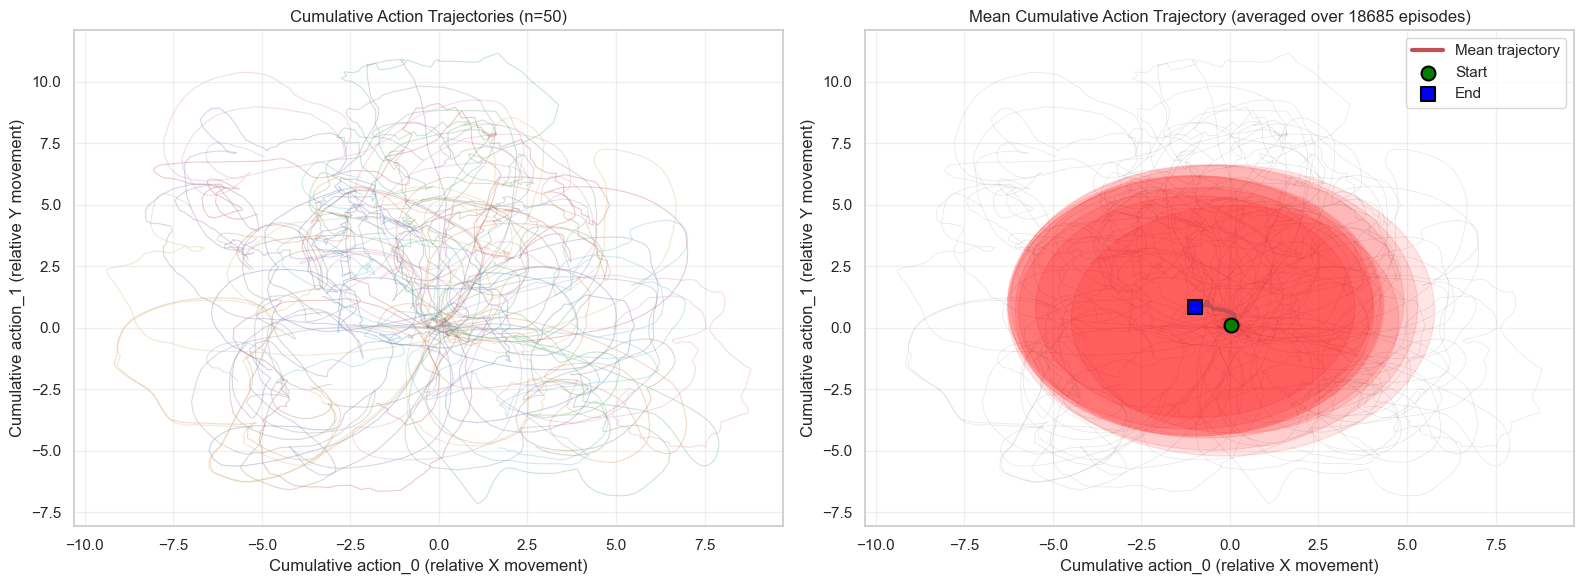

In [45]:
# Plot cumulative action trajectories (path traced by relative movements)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot individual cumulative action trajectories
for ep_idx in sampled_episodes:
    mask = episode_indices == ep_idx
    ep_action_x = action_x[mask]
    ep_action_y = action_y[mask]
    
    # Compute cumulative actions
    ep_cumulative_x = np.cumsum(ep_action_x)
    ep_cumulative_y = np.cumsum(ep_action_y)
    
    axes[0].plot(ep_cumulative_x, ep_cumulative_y, alpha=0.3, linewidth=0.8)

axes[0].set_title(f"Cumulative Action Trajectories (n={num_episodes_to_plot})")
axes[0].set_xlabel("Cumulative action_0 (relative X movement)")
axes[0].set_ylabel("Cumulative action_1 (relative Y movement)")
axes[0].grid(True, alpha=0.3)

# Plot individual cumulative action trajectories with mean
for ep_idx in sampled_episodes:
    mask = episode_indices == ep_idx
    ep_action_x = action_x[mask]
    ep_action_y = action_y[mask]
    
    ep_cumulative_x = np.cumsum(ep_action_x)
    ep_cumulative_y = np.cumsum(ep_action_y)
    
    axes[1].plot(ep_cumulative_x, ep_cumulative_y, alpha=0.2, linewidth=0.5, color='gray')

# Plot mean cumulative action trajectory
axes[1].plot(mean_cumulative_x, mean_cumulative_y, 'r-', linewidth=3, 
            label='Mean trajectory', zorder=10)
axes[1].scatter(mean_cumulative_x[0], mean_cumulative_y[0], c='green', s=100, 
               marker='o', label='Start', zorder=11, edgecolors='black', linewidth=1.5)
axes[1].scatter(mean_cumulative_x[-1], mean_cumulative_y[-1], c='blue', s=100, 
               marker='s', label='End', zorder=11, edgecolors='black', linewidth=1.5)

# Add confidence ellipses at key points
ellipse_indices = np.linspace(0, len(mean_cumulative_x)-1, n_ellipses, dtype=int)
for idx in ellipse_indices:
    circle = plt.Circle((mean_cumulative_x[idx], mean_cumulative_y[idx]), 
                        radius=np.sqrt(std_cumulative_x[idx]**2 + std_cumulative_y[idx]**2),
                        color='red', alpha=0.1, zorder=5)
    axes[1].add_patch(circle)

axes[1].set_title(f"Mean Cumulative Action Trajectory (averaged over {num_episodes} episodes)")
axes[1].set_xlabel("Cumulative action_0 (relative X movement)")
axes[1].set_ylabel("Cumulative action_1 (relative Y movement)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Action values over time: plot action_0 and action_1 as time series with mean trajectories.


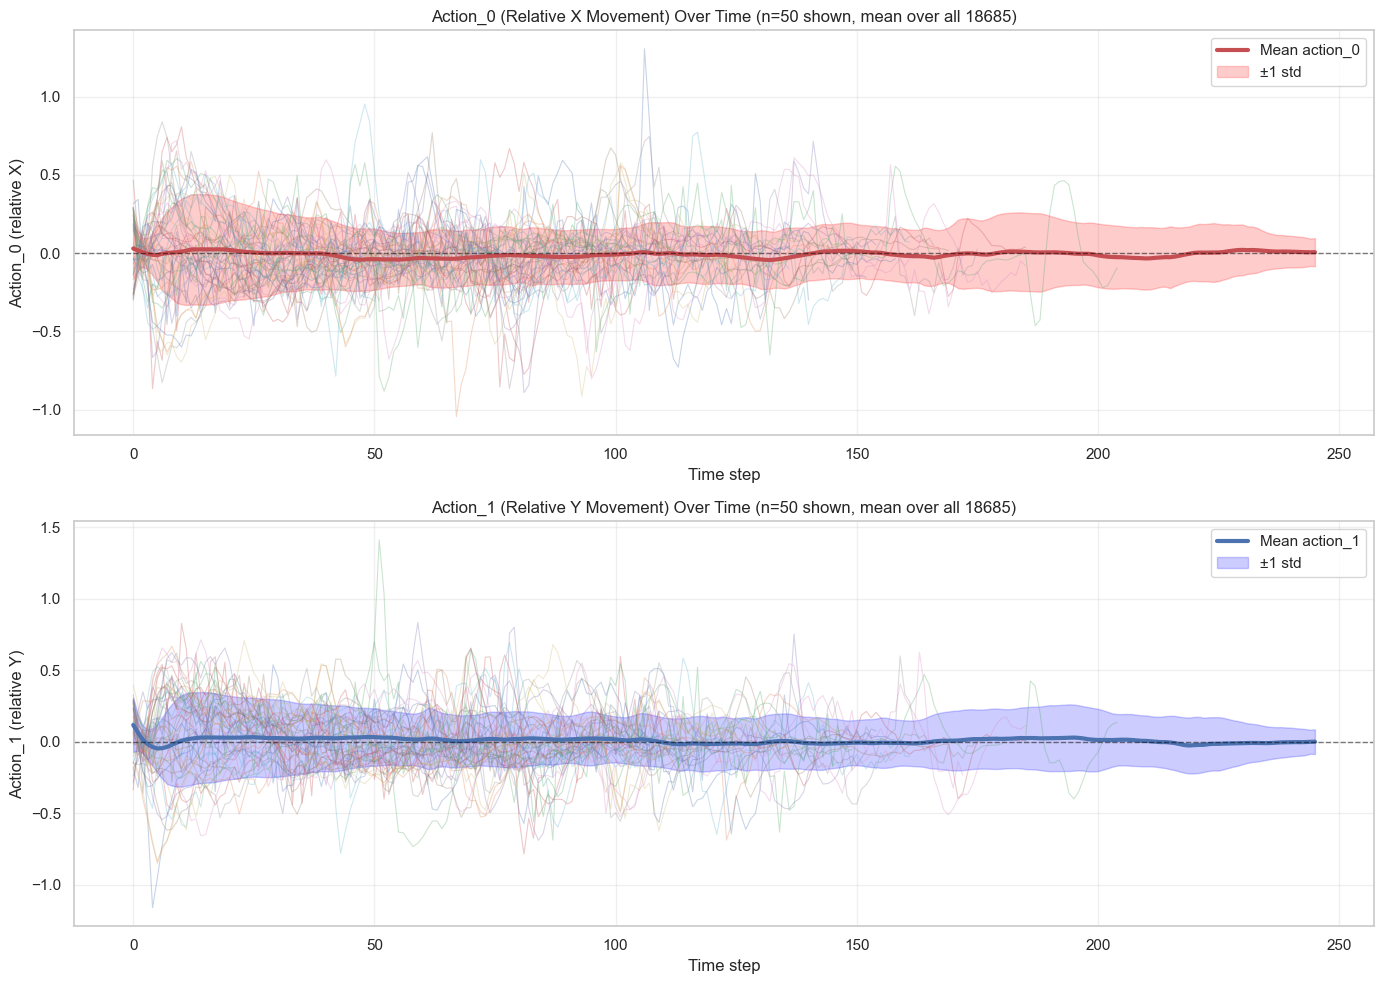

In [46]:
# Plot action values over time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Use the same sampled episodes for consistency
for ep_idx in sampled_episodes:
    mask = episode_indices == ep_idx
    ep_action_x = action_x[mask]
    ep_action_y = action_y[mask]
    ep_steps = step_indices[mask]
    
    axes[0].plot(ep_steps, ep_action_x, alpha=0.3, linewidth=0.8)
    axes[1].plot(ep_steps, ep_action_y, alpha=0.3, linewidth=0.8)

# Plot mean action trajectories over time
time_steps = np.arange(max_ep_length)
axes[0].plot(time_steps, mean_action_x, 'r-', linewidth=3, label='Mean action_0')
axes[0].fill_between(time_steps, mean_action_x - std_action_x, mean_action_x + std_action_x, 
                     color='red', alpha=0.2, label='±1 std')
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

axes[1].plot(time_steps, mean_action_y, 'b-', linewidth=3, label='Mean action_1')
axes[1].fill_between(time_steps, mean_action_y - std_action_y, mean_action_y + std_action_y, 
                     color='blue', alpha=0.2, label='±1 std')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)

axes[0].set_title(f"Action_0 (Relative X Movement) Over Time (n={num_episodes_to_plot} shown, mean over all {num_episodes})")
axes[0].set_xlabel("Time step")
axes[0].set_ylabel("Action_0 (relative X)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title(f"Action_1 (Relative Y Movement) Over Time (n={num_episodes_to_plot} shown, mean over all {num_episodes})")
axes[1].set_xlabel("Time step")
axes[1].set_ylabel("Action_1 (relative Y)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Comparison: State positions vs Cumulative actions to see relationship between absolute positions and relative movements.


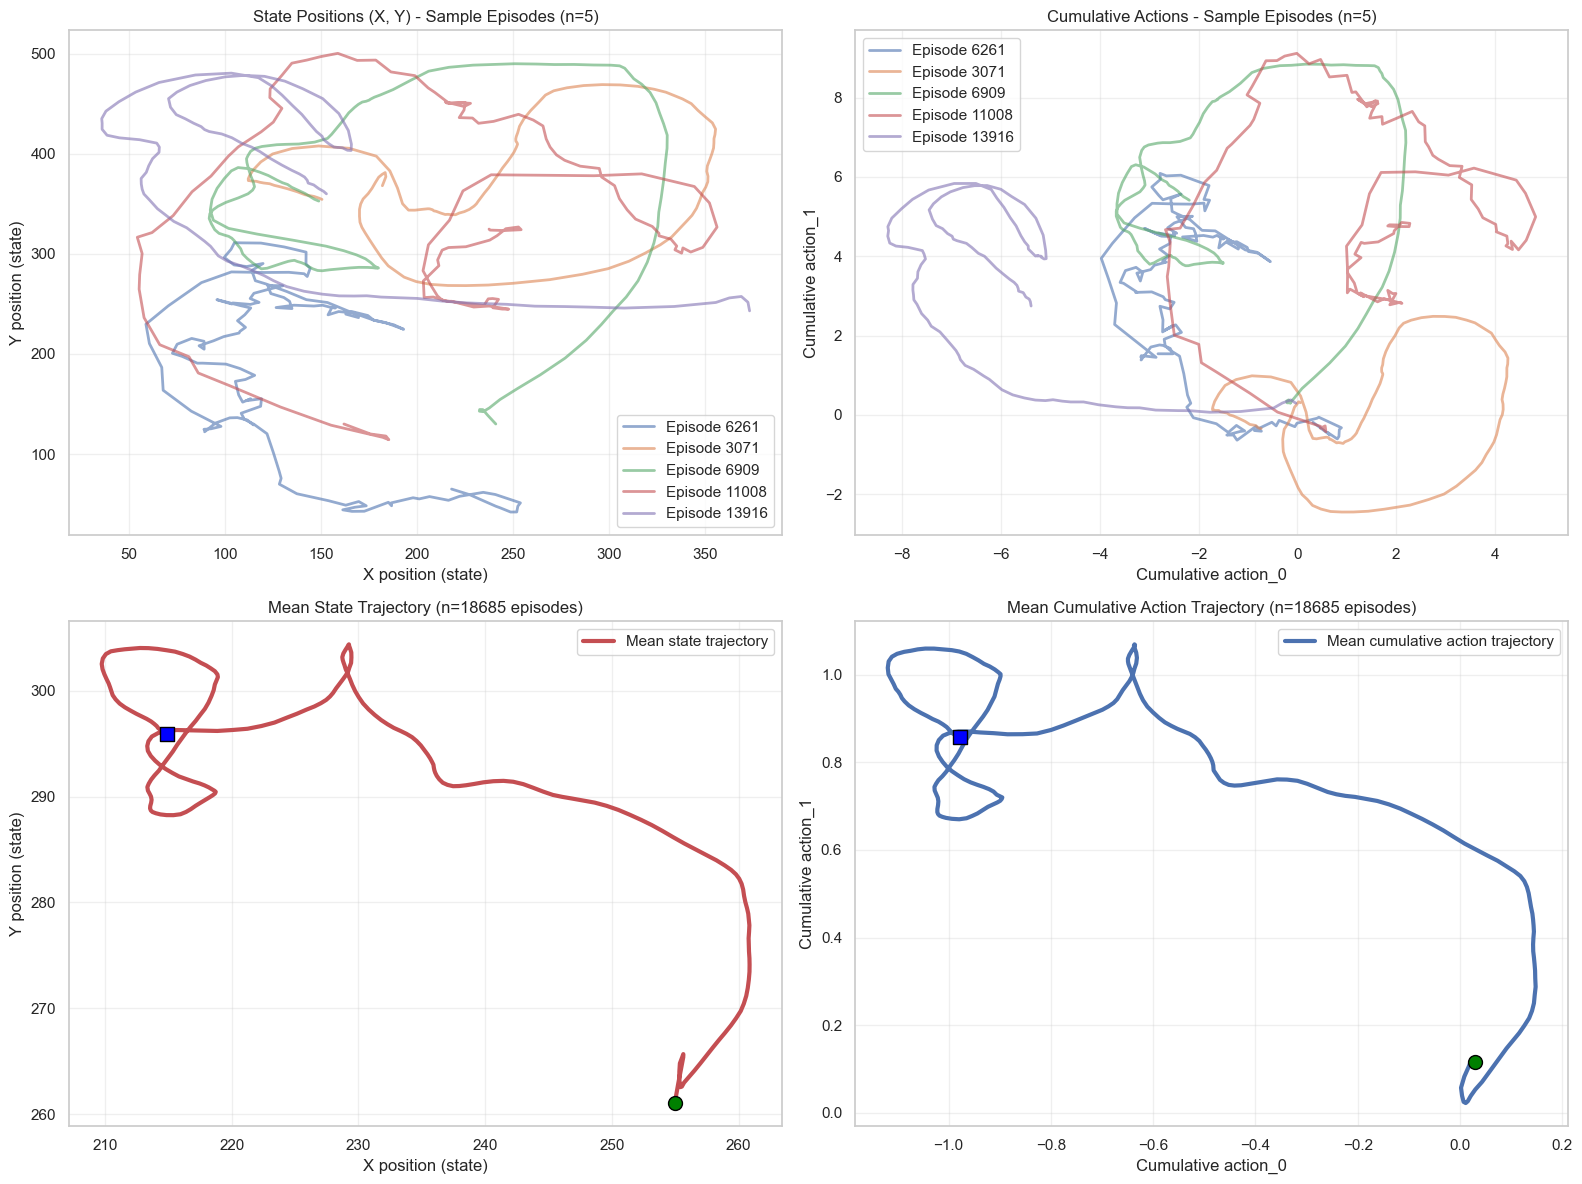


=== Comparison Statistics ===
State position range - X: [-153.007, 666.138]
State position range - Y: [-90.595, 723.640]
Mean trajectory end point (state) - X: 214.903, Y: 295.955
Mean trajectory end point (cumulative action) - X: -0.977, Y: 0.858


In [47]:
# Compare state positions with cumulative actions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot a few example episodes to compare state trajectory vs cumulative action trajectory
n_comparison_episodes = 5
comparison_episodes = sampled_episodes[:n_comparison_episodes]

for i, ep_idx in enumerate(comparison_episodes):
    mask = episode_indices == ep_idx
    ep_x = x_coords[mask]
    ep_y = y_coords[mask]
    ep_action_x = action_x[mask]
    ep_action_y = action_y[mask]
    ep_cumulative_x = np.cumsum(ep_action_x)
    ep_cumulative_y = np.cumsum(ep_action_y)
    
    # State trajectory
    axes[0, 0].plot(ep_x, ep_y, alpha=0.6, linewidth=2, label=f'Episode {ep_idx}')
    # Cumulative action trajectory
    axes[0, 1].plot(ep_cumulative_x, ep_cumulative_y, alpha=0.6, linewidth=2, label=f'Episode {ep_idx}')

# Plot mean trajectories
axes[1, 0].plot(mean_x, mean_y, 'r-', linewidth=3, label='Mean state trajectory')
axes[1, 0].scatter(mean_x[0], mean_y[0], c='green', s=100, marker='o', zorder=10, edgecolors='black')
axes[1, 0].scatter(mean_x[-1], mean_y[-1], c='blue', s=100, marker='s', zorder=10, edgecolors='black')

axes[1, 1].plot(mean_cumulative_x, mean_cumulative_y, 'b-', linewidth=3, label='Mean cumulative action trajectory')
axes[1, 1].scatter(mean_cumulative_x[0], mean_cumulative_y[0], c='green', s=100, marker='o', zorder=10, edgecolors='black')
axes[1, 1].scatter(mean_cumulative_x[-1], mean_cumulative_y[-1], c='blue', s=100, marker='s', zorder=10, edgecolors='black')

# Formatting
axes[0, 0].set_title(f"State Positions (X, Y) - Sample Episodes (n={n_comparison_episodes})")
axes[0, 0].set_xlabel("X position (state)")
axes[0, 0].set_ylabel("Y position (state)")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_title(f"Cumulative Actions - Sample Episodes (n={n_comparison_episodes})")
axes[0, 1].set_xlabel("Cumulative action_0")
axes[0, 1].set_ylabel("Cumulative action_1")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_title(f"Mean State Trajectory (n={num_episodes} episodes)")
axes[1, 0].set_xlabel("X position (state)")
axes[1, 0].set_ylabel("Y position (state)")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_title(f"Mean Cumulative Action Trajectory (n={num_episodes} episodes)")
axes[1, 1].set_xlabel("Cumulative action_0")
axes[1, 1].set_ylabel("Cumulative action_1")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n=== Comparison Statistics ===")
print(f"State position range - X: [{x_coords.min():.3f}, {x_coords.max():.3f}]")
print(f"State position range - Y: [{y_coords.min():.3f}, {y_coords.max():.3f}]")
print(f"Mean trajectory end point (state) - X: {mean_x[-1]:.3f}, Y: {mean_y[-1]:.3f}")
print(f"Mean trajectory end point (cumulative action) - X: {mean_cumulative_x[-1]:.3f}, Y: {mean_cumulative_y[-1]:.3f}")


## Multi-modality Analysis of Actions

Exploring whether actions exhibit multi-modal distributions and how they vary under different conditions.


### 1. Overall Action Distribution - Multi-modality Check


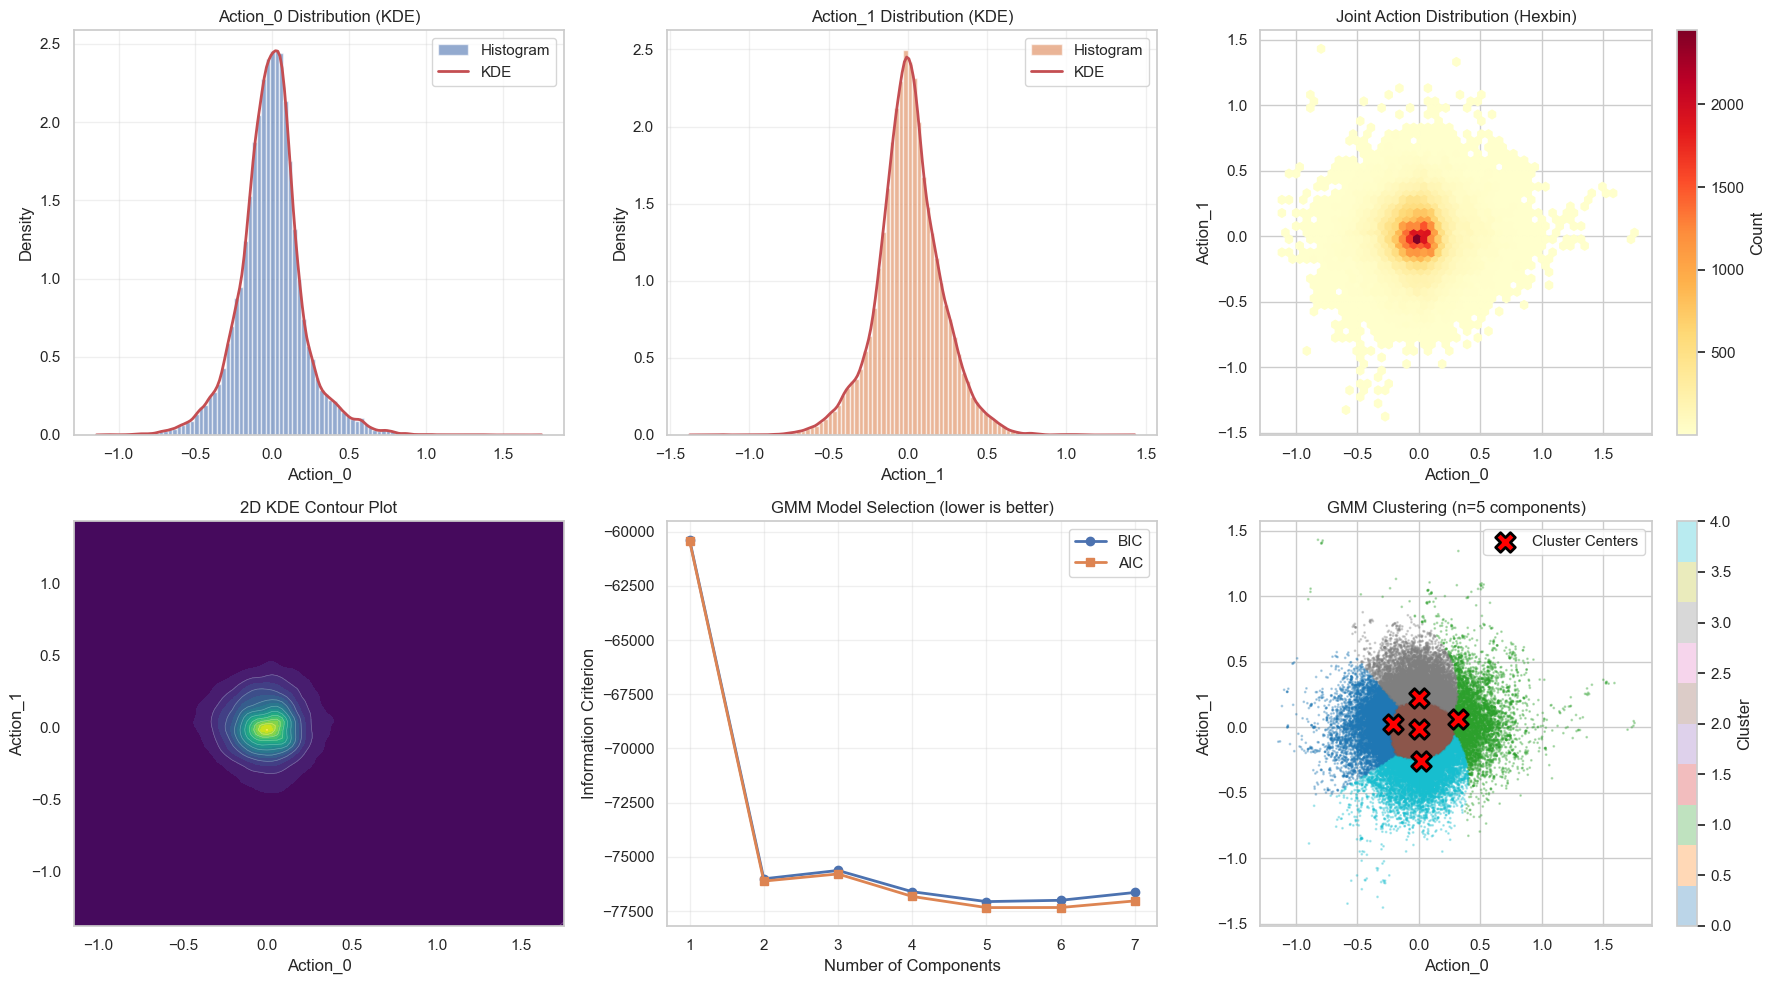

Best number of GMM components (by BIC): 5

Cluster centers:
  Cluster 0: action_0=-0.2148, action_1=0.0239
  Cluster 1: action_0=0.3167, action_1=0.0671
  Cluster 2: action_0=-0.0020, action_1=-0.0155
  Cluster 3: action_0=-0.0011, action_1=0.2259
  Cluster 4: action_0=0.0196, action_1=-0.2564

Cluster proportions:
  Cluster 0: 16.63%
  Cluster 1: 8.10%
  Cluster 2: 44.69%
  Cluster 3: 17.22%
  Cluster 4: 13.36%


In [48]:
# Overall action distribution with KDE to detect multi-modality
from scipy import stats
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# Use a larger sample for better distribution estimation
action_analysis_sample_size = min(100000, len(actions))
action_analysis_idx = rng.choice(len(actions), size=action_analysis_sample_size, replace=False)
actions_sample = actions[action_analysis_idx]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Marginal distributions with KDE
axes[0, 0].hist(actions_sample[:, 0], bins=100, density=True, alpha=0.6, color='C0', label='Histogram')
kde_0 = stats.gaussian_kde(actions_sample[:, 0])
x_range = np.linspace(actions_sample[:, 0].min(), actions_sample[:, 0].max(), 200)
axes[0, 0].plot(x_range, kde_0(x_range), 'r-', linewidth=2, label='KDE')
axes[0, 0].set_title('Action_0 Distribution (KDE)')
axes[0, 0].set_xlabel('Action_0')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(actions_sample[:, 1], bins=100, density=True, alpha=0.6, color='C1', label='Histogram')
kde_1 = stats.gaussian_kde(actions_sample[:, 1])
y_range = np.linspace(actions_sample[:, 1].min(), actions_sample[:, 1].max(), 200)
axes[0, 1].plot(y_range, kde_1(y_range), 'r-', linewidth=2, label='KDE')
axes[0, 1].set_title('Action_1 Distribution (KDE)')
axes[0, 1].set_xlabel('Action_1')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 2. Joint distribution with hexbin (density)
hexbin = axes[0, 2].hexbin(actions_sample[:, 0], actions_sample[:, 1], 
                           gridsize=50, cmap='YlOrRd', mincnt=1)
axes[0, 2].set_title('Joint Action Distribution (Hexbin)')
axes[0, 2].set_xlabel('Action_0')
axes[0, 2].set_ylabel('Action_1')
plt.colorbar(hexbin, ax=axes[0, 2], label='Count')

# 3. 2D KDE contour plot
from scipy.stats import gaussian_kde
xy = np.vstack([actions_sample[:, 0], actions_sample[:, 1]])
kde_2d = gaussian_kde(xy)

# Create grid for evaluation
x_grid = np.linspace(actions_sample[:, 0].min(), actions_sample[:, 0].max(), 100)
y_grid = np.linspace(actions_sample[:, 1].min(), actions_sample[:, 1].max(), 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X_grid.ravel(), Y_grid.ravel()])
Z = np.reshape(kde_2d(positions).T, X_grid.shape)

axes[1, 0].contourf(X_grid, Y_grid, Z, levels=20, cmap='viridis')
axes[1, 0].contour(X_grid, Y_grid, Z, levels=10, colors='white', alpha=0.3, linewidths=0.5)
axes[1, 0].set_title('2D KDE Contour Plot')
axes[1, 0].set_xlabel('Action_0')
axes[1, 0].set_ylabel('Action_1')

# 4. Fit Gaussian Mixture Model to detect modes
n_components_range = range(1, 8)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(actions_sample)
    bic_scores.append(gmm.bic(actions_sample))
    aic_scores.append(gmm.aic(actions_sample))

axes[1, 1].plot(n_components_range, bic_scores, 'o-', label='BIC', linewidth=2)
axes[1, 1].plot(n_components_range, aic_scores, 's-', label='AIC', linewidth=2)
axes[1, 1].set_title('GMM Model Selection (lower is better)')
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Information Criterion')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 5. Fit best GMM and visualize clusters
best_n_components = np.argmin(bic_scores) + 1
gmm_best = GaussianMixture(n_components=best_n_components, random_state=42)
cluster_labels = gmm_best.fit_predict(actions_sample)

scatter = axes[1, 2].scatter(actions_sample[:, 0], actions_sample[:, 1], 
                             c=cluster_labels, cmap='tab10', alpha=0.3, s=1)
axes[1, 2].scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], 
                  c='red', marker='X', s=200, edgecolors='black', linewidth=2, 
                  label='Cluster Centers', zorder=10)
axes[1, 2].set_title(f'GMM Clustering (n={best_n_components} components)')
axes[1, 2].set_xlabel('Action_0')
axes[1, 2].set_ylabel('Action_1')
axes[1, 2].legend()
plt.colorbar(scatter, ax=axes[1, 2], label='Cluster')

plt.tight_layout()
plt.show()

print(f"Best number of GMM components (by BIC): {best_n_components}")
print(f"\nCluster centers:")
for i, mean in enumerate(gmm_best.means_):
    print(f"  Cluster {i}: action_0={mean[0]:.4f}, action_1={mean[1]:.4f}")
print(f"\nCluster proportions:")
for i, weight in enumerate(gmm_best.weights_):
    print(f"  Cluster {i}: {weight*100:.2f}%")


### 2. Conditional Distributions by Timestep (Episode Phase)


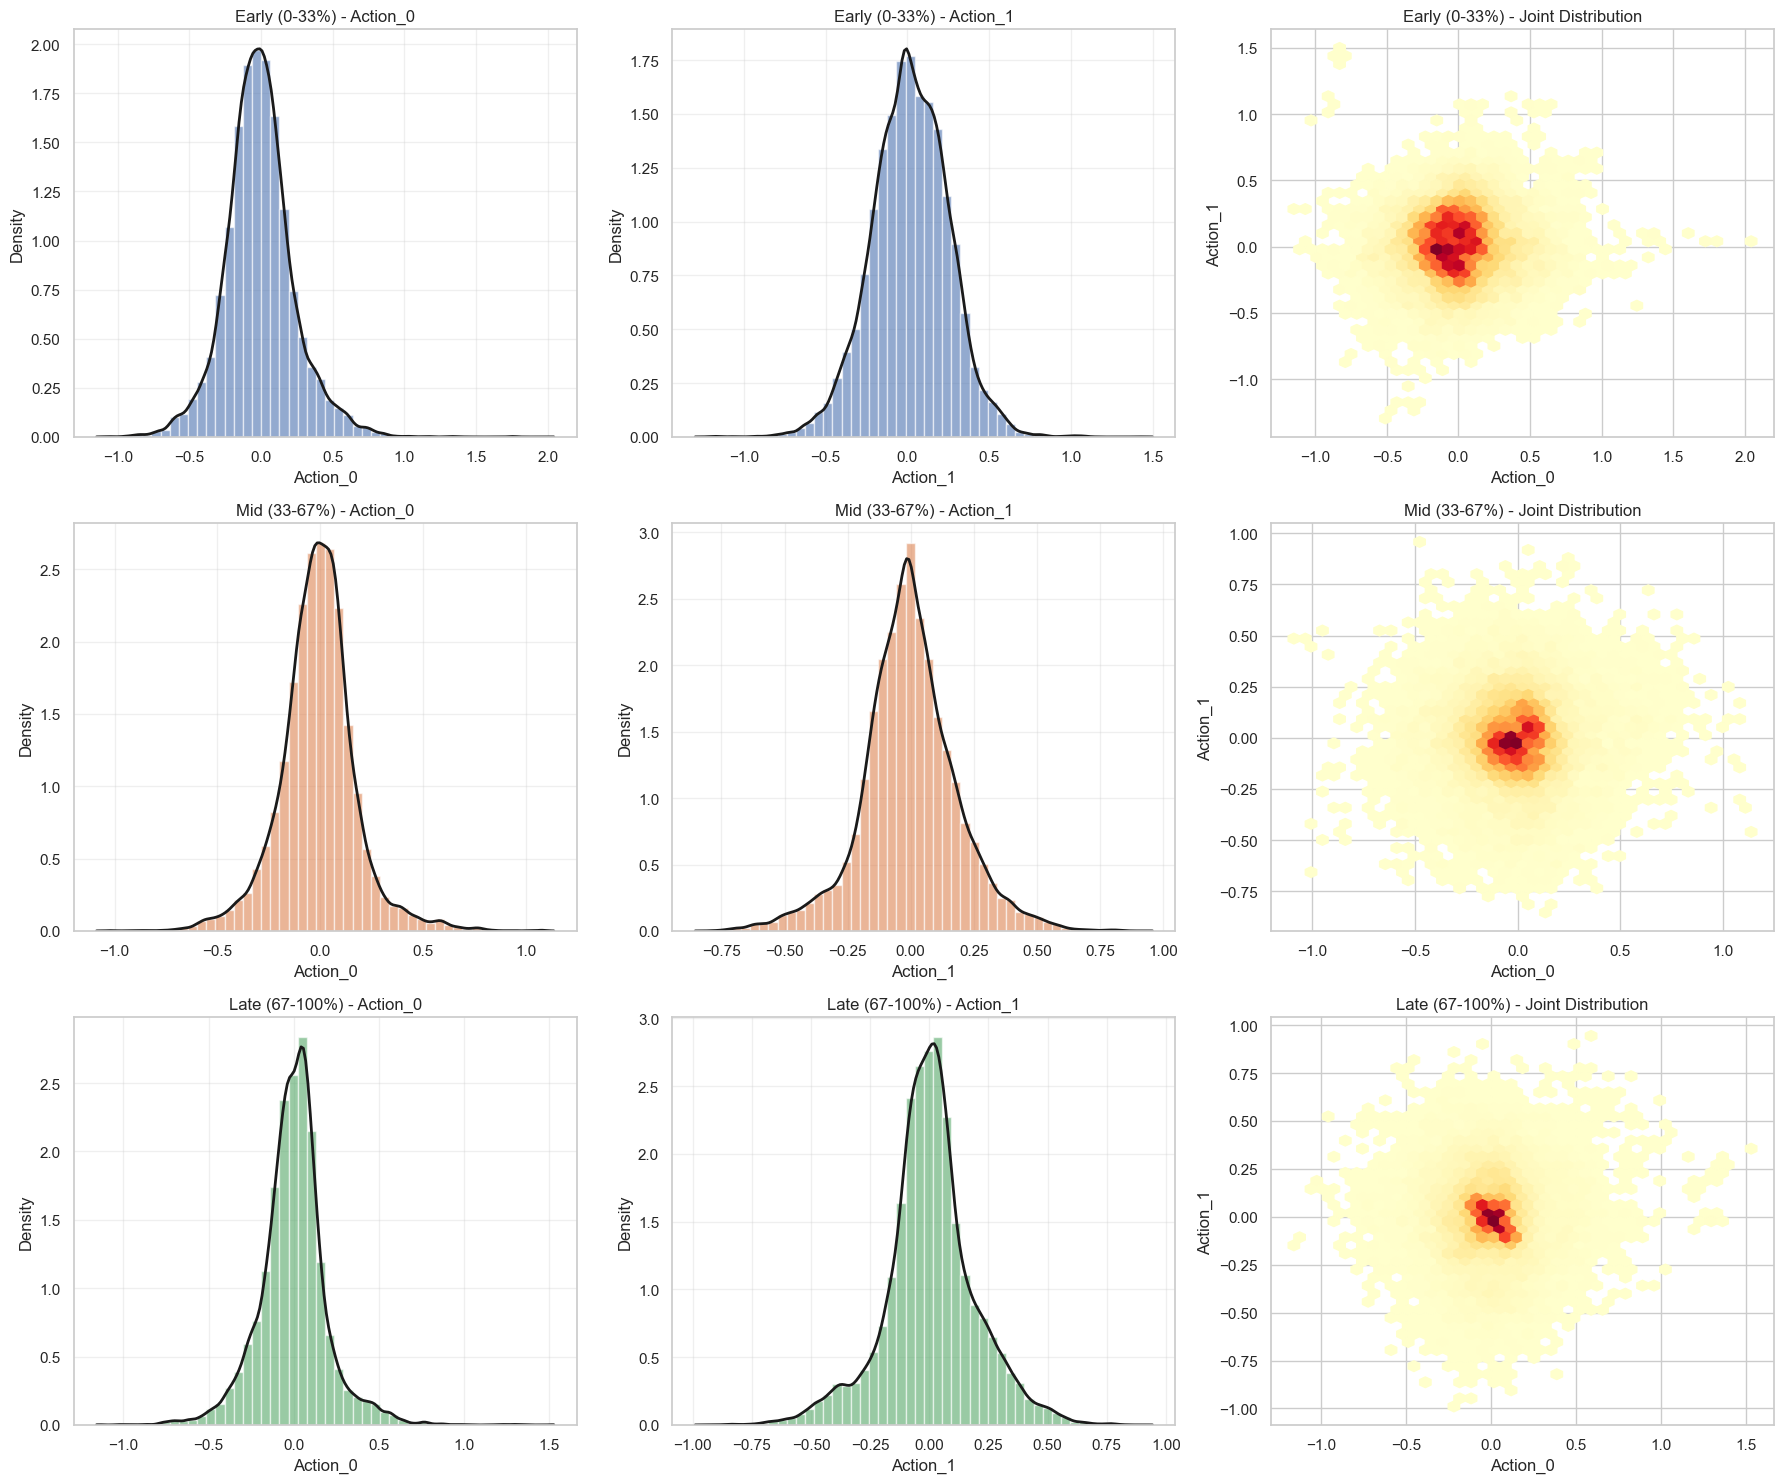

Action Statistics by Episode Phase:

Early (0-33%):
  Sample size: 773,862
  Action_0 - mean: -0.0116, std: 0.2386
  Action_1 - mean: 0.0197, std: 0.2363
  Correlation: 0.0314

Mid (33-67%):
  Sample size: 788,911
  Action_0 - mean: -0.0112, std: 0.1865
  Action_1 - mean: -0.0033, std: 0.1879
  Correlation: 0.0257

Late (67-100%):
  Sample size: 773,963
  Action_0 - mean: -0.0006, std: 0.1970
  Action_1 - mean: 0.0044, std: 0.1922
  Correlation: -0.0247


In [49]:
# Analyze how action distributions change throughout episodes
# Bucket timesteps into early, mid, and late phases

# Normalize step indices within each episode (0 = start, 1 = end)
normalized_steps = np.zeros(len(step_indices))
for ep_idx in range(num_episodes):
    mask = episode_indices == ep_idx
    ep_length = mask.sum()
    if ep_length > 1:
        normalized_steps[mask] = step_indices[mask] / (ep_length - 1)

# Define phase buckets
phase_labels = ['Early (0-33%)', 'Mid (33-67%)', 'Late (67-100%)']
phase_masks = [
    normalized_steps < 0.33,
    (normalized_steps >= 0.33) & (normalized_steps < 0.67),
    normalized_steps >= 0.67
]

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# For each phase
for phase_idx, (phase_mask, phase_label) in enumerate(zip(phase_masks, phase_labels)):
    phase_actions = actions[phase_mask]
    
    # Sample for visualization
    phase_sample_size = min(50000, len(phase_actions))
    phase_sample_idx = rng.choice(len(phase_actions), size=phase_sample_size, replace=False)
    phase_sample = phase_actions[phase_sample_idx]
    
    # Marginal distribution - action_0
    axes[phase_idx, 0].hist(phase_sample[:, 0], bins=50, density=True, alpha=0.6, color=f'C{phase_idx}')
    kde = stats.gaussian_kde(phase_sample[:, 0])
    x_range = np.linspace(phase_sample[:, 0].min(), phase_sample[:, 0].max(), 200)
    axes[phase_idx, 0].plot(x_range, kde(x_range), 'k-', linewidth=2)
    axes[phase_idx, 0].set_title(f'{phase_label} - Action_0')
    axes[phase_idx, 0].set_xlabel('Action_0')
    axes[phase_idx, 0].set_ylabel('Density')
    axes[phase_idx, 0].grid(True, alpha=0.3)
    
    # Marginal distribution - action_1
    axes[phase_idx, 1].hist(phase_sample[:, 1], bins=50, density=True, alpha=0.6, color=f'C{phase_idx}')
    kde = stats.gaussian_kde(phase_sample[:, 1])
    y_range = np.linspace(phase_sample[:, 1].min(), phase_sample[:, 1].max(), 200)
    axes[phase_idx, 1].plot(y_range, kde(y_range), 'k-', linewidth=2)
    axes[phase_idx, 1].set_title(f'{phase_label} - Action_1')
    axes[phase_idx, 1].set_xlabel('Action_1')
    axes[phase_idx, 1].set_ylabel('Density')
    axes[phase_idx, 1].grid(True, alpha=0.3)
    
    # Joint distribution
    axes[phase_idx, 2].hexbin(phase_sample[:, 0], phase_sample[:, 1], 
                              gridsize=40, cmap='YlOrRd', mincnt=1)
    axes[phase_idx, 2].set_title(f'{phase_label} - Joint Distribution')
    axes[phase_idx, 2].set_xlabel('Action_0')
    axes[phase_idx, 2].set_ylabel('Action_1')

plt.tight_layout()
plt.show()

# Statistics by phase
print("Action Statistics by Episode Phase:")
print("=" * 60)
for phase_idx, (phase_mask, phase_label) in enumerate(zip(phase_masks, phase_labels)):
    phase_actions = actions[phase_mask]
    print(f"\n{phase_label}:")
    print(f"  Sample size: {len(phase_actions):,}")
    print(f"  Action_0 - mean: {phase_actions[:, 0].mean():.4f}, std: {phase_actions[:, 0].std():.4f}")
    print(f"  Action_1 - mean: {phase_actions[:, 1].mean():.4f}, std: {phase_actions[:, 1].std():.4f}")
    print(f"  Correlation: {np.corrcoef(phase_actions[:, 0], phase_actions[:, 1])[0, 1]:.4f}")


### 3. Conditional Distributions by State Regions


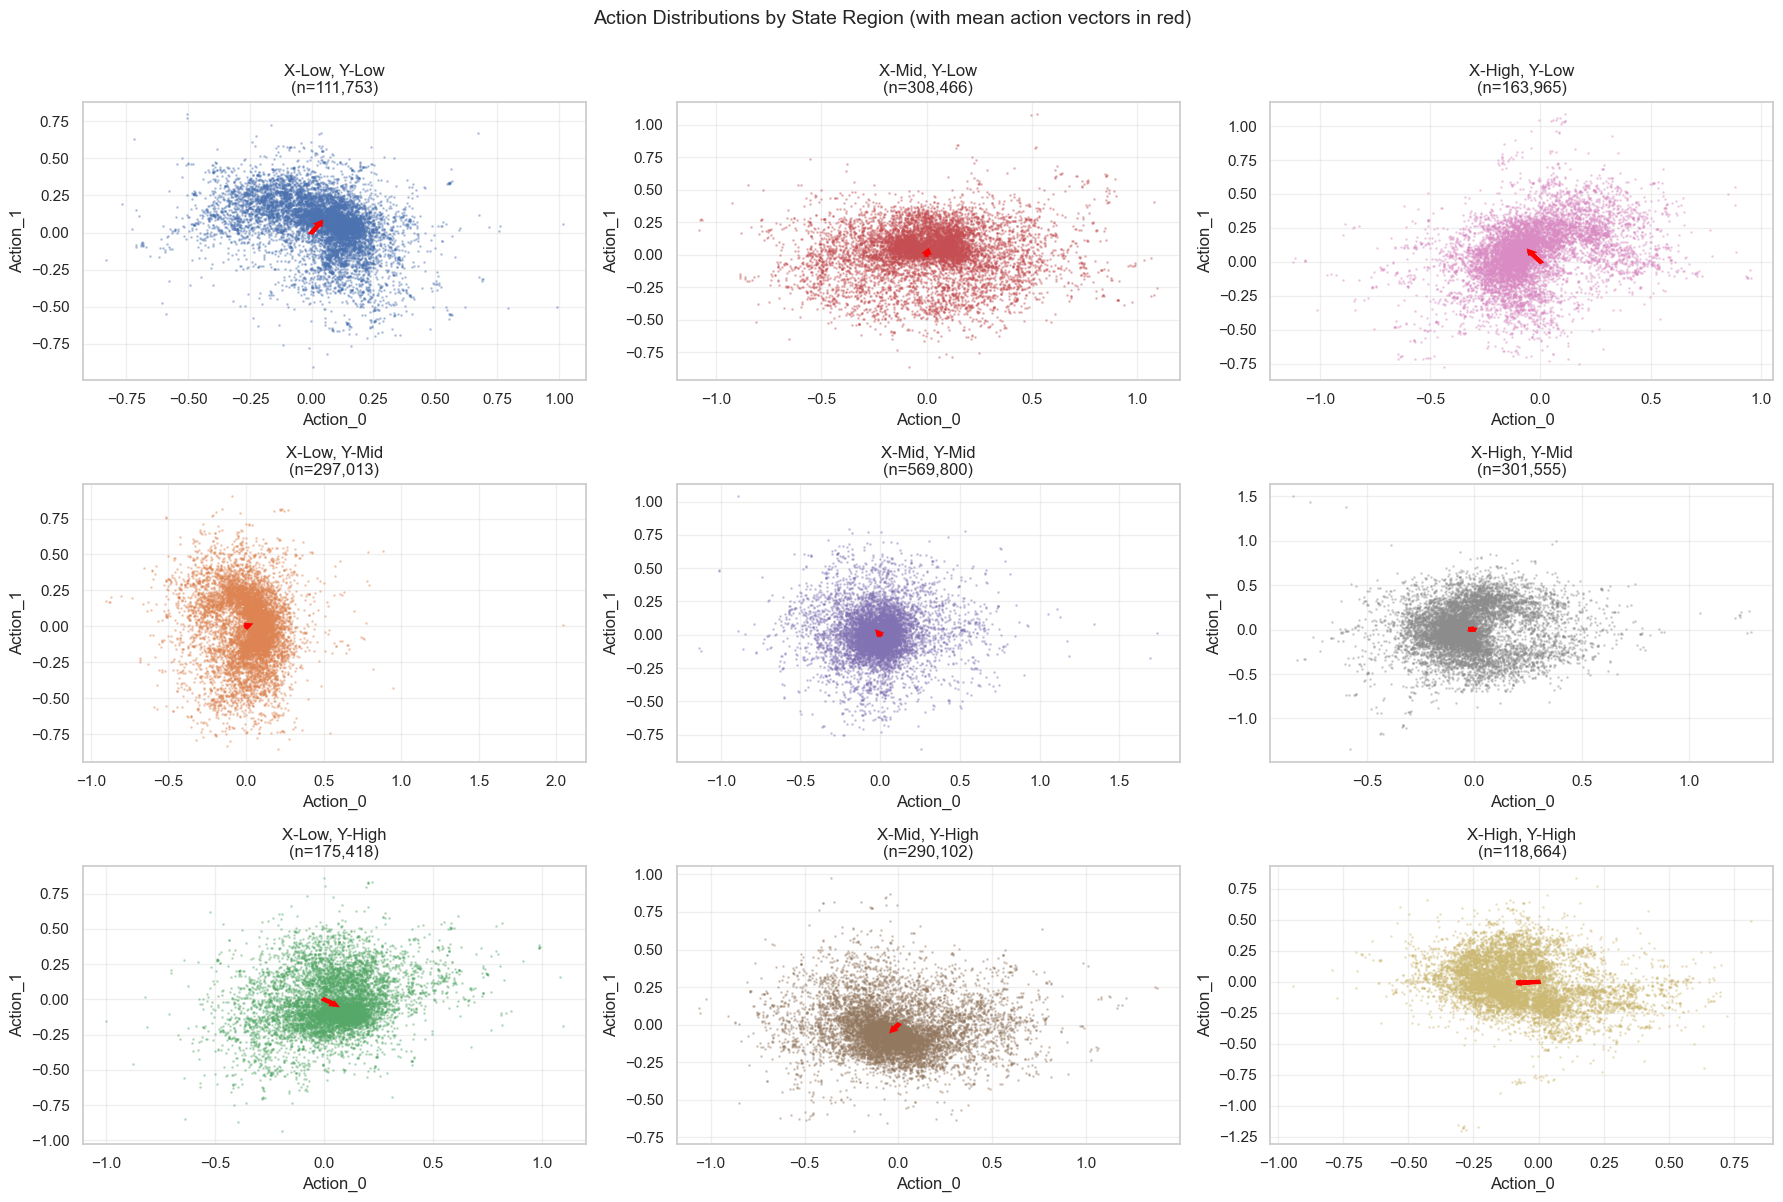

Action Statistics by State Region:

X-Low, Y-Low:
  Sample size: 111,753
  Action_0 - mean: 0.0315, std: 0.1809
  Action_1 - mean: 0.0578, std: 0.1899
  Correlation: -0.3793

X-Low, Y-Mid:
  Sample size: 297,013
  Action_0 - mean: 0.0098, std: 0.1614
  Action_1 - mean: 0.0040, std: 0.2398
  Correlation: -0.1216

X-Low, Y-High:
  Sample size: 175,418
  Action_0 - mean: 0.0432, std: 0.1864
  Action_1 - mean: -0.0317, std: 0.1891
  Correlation: 0.2296

X-Mid, Y-Low:
  Sample size: 308,466
  Action_0 - mean: 0.0043, std: 0.2601
  Action_1 - mean: 0.0197, std: 0.1931
  Correlation: 0.0458

X-Mid, Y-Mid:
  Sample size: 569,800
  Action_0 - mean: -0.0076, std: 0.1843
  Action_1 - mean: 0.0095, std: 0.1734
  Correlation: 0.0417

X-Mid, Y-High:
  Sample size: 290,102
  Action_0 - mean: -0.0261, std: 0.2602
  Action_1 - mean: -0.0300, std: 0.1708
  Correlation: -0.0894

X-High, Y-Low:
  Sample size: 163,965
  Action_0 - mean: -0.0440, std: 0.2094
  Action_1 - mean: 0.0667, std: 0.2194
  Correlat

In [50]:
# Analyze how actions vary based on position in state space
# Bucket states by X and Y position into regions

# Create spatial buckets (divide space into grid)
x_state = states[:, 0]
y_state = states[:, 1]

# Define quartiles for bucketing
x_quartiles = np.percentile(x_state, [25, 50, 75])
y_quartiles = np.percentile(y_state, [25, 50, 75])

# Create 3x3 grid of regions (low/mid/high for X and Y)
def get_bucket(value, quartiles):
    if value < quartiles[0]:
        return 0  # low
    elif value < quartiles[2]:
        return 1  # mid
    else:
        return 2  # high

x_buckets = np.array([get_bucket(x, x_quartiles) for x in x_state])
y_buckets = np.array([get_bucket(y, y_quartiles) for y in y_state])

bucket_labels = ['Low', 'Mid', 'High']
region_labels = [f'X-{bucket_labels[i]}, Y-{bucket_labels[j]}' 
                 for i in range(3) for j in range(3)]

# Visualize action distributions for different state regions
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i in range(3):
    for j in range(3):
        region_mask = (x_buckets == i) & (y_buckets == j)
        region_actions = actions[region_mask]
        
        if len(region_actions) > 100:  # Only plot if enough samples
            # Sample for efficiency
            region_sample_size = min(10000, len(region_actions))
            region_sample_idx = rng.choice(len(region_actions), size=region_sample_size, replace=False)
            region_sample = region_actions[region_sample_idx]
            
            axes[j, i].scatter(region_sample[:, 0], region_sample[:, 1], 
                             alpha=0.3, s=1, c=f'C{i*3+j}')
            axes[j, i].set_title(f'X-{bucket_labels[i]}, Y-{bucket_labels[j]}\n(n={len(region_actions):,})')
            axes[j, i].set_xlabel('Action_0')
            axes[j, i].set_ylabel('Action_1')
            axes[j, i].grid(True, alpha=0.3)
            
            # Add mean action vector
            mean_action = region_actions.mean(axis=0)
            axes[j, i].arrow(0, 0, mean_action[0], mean_action[1], 
                           head_width=0.01, head_length=0.01, fc='red', ec='red', 
                           linewidth=3, zorder=10)
        else:
            axes[j, i].text(0.5, 0.5, 'Insufficient data', 
                          ha='center', va='center', transform=axes[j, i].transAxes)
            axes[j, i].set_title(f'X-{bucket_labels[i]}, Y-{bucket_labels[j]}')

plt.suptitle('Action Distributions by State Region (with mean action vectors in red)', y=1.0, fontsize=14)
plt.tight_layout()
plt.show()

# Print statistics for each region
print("Action Statistics by State Region:")
print("=" * 80)
for i in range(3):
    for j in range(3):
        region_mask = (x_buckets == i) & (y_buckets == j)
        region_actions = actions[region_mask]
        if len(region_actions) > 0:
            print(f"\nX-{bucket_labels[i]}, Y-{bucket_labels[j]}:")
            print(f"  Sample size: {len(region_actions):,}")
            print(f"  Action_0 - mean: {region_actions[:, 0].mean():.4f}, std: {region_actions[:, 0].std():.4f}")
            print(f"  Action_1 - mean: {region_actions[:, 1].mean():.4f}, std: {region_actions[:, 1].std():.4f}")
            if len(region_actions) > 1:
                print(f"  Correlation: {np.corrcoef(region_actions[:, 0], region_actions[:, 1])[0, 1]:.4f}")


### 4. Conditional Distributions by Proprioceptive State


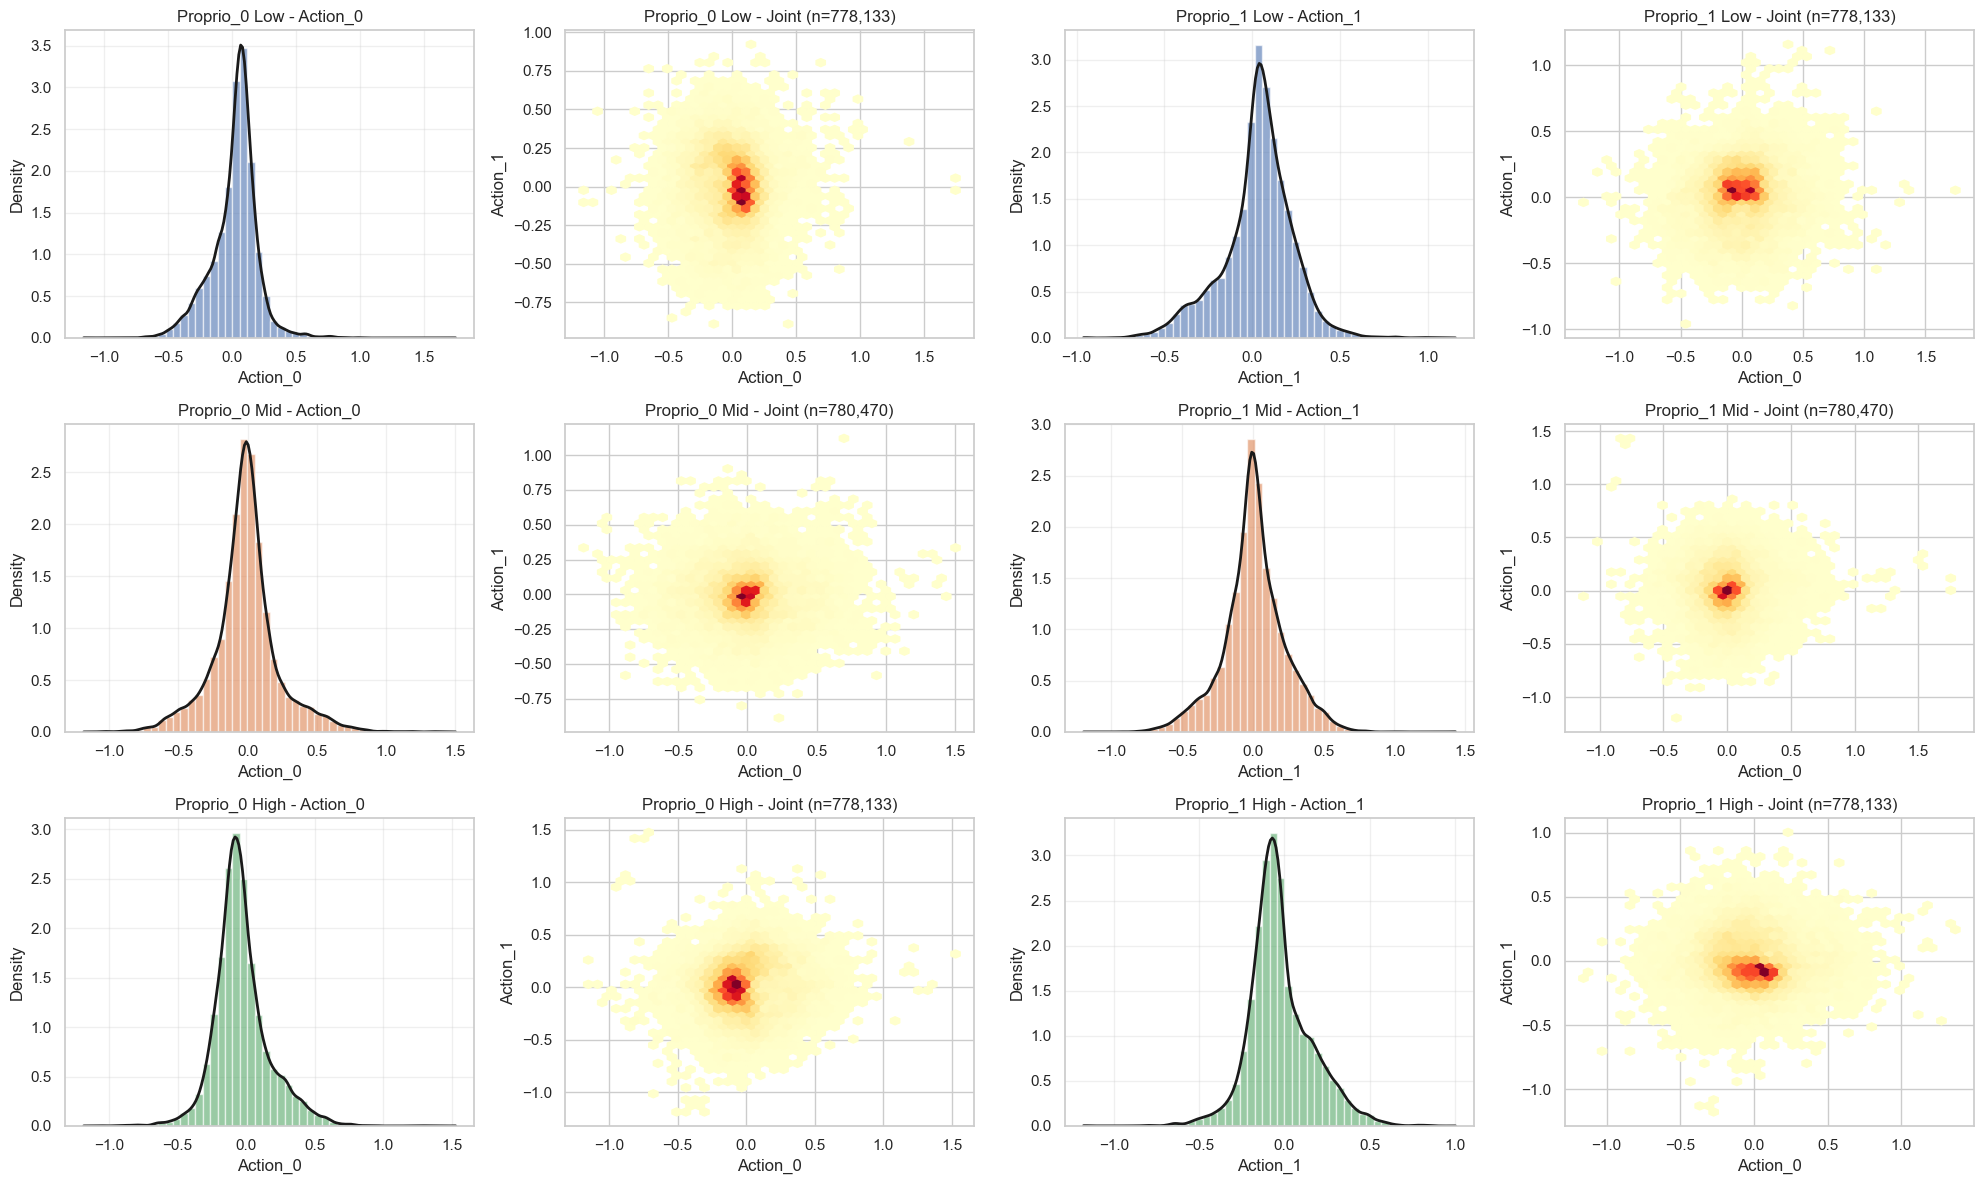

Action Statistics by Proprioceptive State:

Conditioning on Proprio_0:

  Low (proprio_0 in [-153.007, 166.487]):
    Sample size: 778,133
    Action_0 - mean: 0.0198, std: 0.1820
    Action_1 - mean: 0.0032, std: 0.2067

  Mid (proprio_0 in [166.487, 281.333]):
    Sample size: 780,470
    Action_0 - mean: -0.0096, std: 0.2358
    Action_1 - mean: -0.0009, std: 0.1808

  High (proprio_0 in [281.333, 666.138]):
    Sample size: 778,133
    Action_0 - mean: -0.0336, std: 0.2004
    Action_1 - mean: 0.0183, std: 0.2294

Conditioning on Proprio_1:

  Low (proprio_1 in [-90.595, 242.679]):
    Sample size: 778,133
    Action_0 - mean: -0.0074, std: 0.2203
    Action_1 - mean: 0.0344, std: 0.2031

  Mid (proprio_1 in [242.679, 348.165]):
    Sample size: 780,470
    Action_0 - mean: -0.0022, std: 0.1812
    Action_1 - mean: 0.0087, std: 0.2227

  High (proprio_1 in [348.165, 723.640]):
    Sample size: 778,133
    Action_0 - mean: -0.0138, std: 0.2214
    Action_1 - mean: -0.0226, std: 0.18

In [51]:
# Analyze how actions vary based on proprioceptive state
# Proprio has 4 dimensions - let's analyze the first 2

proprio_0 = proprio[:, 0]
proprio_1 = proprio[:, 1]

# Define buckets based on tertiles
p0_tertiles = np.percentile(proprio_0, [33.3, 66.7])
p1_tertiles = np.percentile(proprio_1, [33.3, 66.7])

def get_tertile_bucket(value, tertiles):
    if value < tertiles[0]:
        return 0  # low
    elif value < tertiles[1]:
        return 1  # mid
    else:
        return 2  # high

p0_buckets = np.array([get_tertile_bucket(p, p0_tertiles) for p in proprio_0])
p1_buckets = np.array([get_tertile_bucket(p, p1_tertiles) for p in proprio_1])

fig, axes = plt.subplots(3, 4, figsize=(20, 12))

# Analyze conditioning on proprio_0 (first dimension)
for bucket_idx in range(3):
    bucket_mask = p0_buckets == bucket_idx
    bucket_actions = actions[bucket_mask]
    
    # Sample for efficiency
    bucket_sample_size = min(30000, len(bucket_actions))
    bucket_sample_idx = rng.choice(len(bucket_actions), size=bucket_sample_size, replace=False)
    bucket_sample = bucket_actions[bucket_sample_idx]
    
    # KDE for action_0
    axes[bucket_idx, 0].hist(bucket_sample[:, 0], bins=50, density=True, alpha=0.6, color=f'C{bucket_idx}')
    kde = stats.gaussian_kde(bucket_sample[:, 0])
    x_range = np.linspace(bucket_sample[:, 0].min(), bucket_sample[:, 0].max(), 200)
    axes[bucket_idx, 0].plot(x_range, kde(x_range), 'k-', linewidth=2)
    axes[bucket_idx, 0].set_title(f'Proprio_0 {bucket_labels[bucket_idx]} - Action_0')
    axes[bucket_idx, 0].set_xlabel('Action_0')
    axes[bucket_idx, 0].set_ylabel('Density')
    axes[bucket_idx, 0].grid(True, alpha=0.3)
    
    # Joint distribution
    axes[bucket_idx, 1].hexbin(bucket_sample[:, 0], bucket_sample[:, 1], 
                              gridsize=40, cmap='YlOrRd', mincnt=1)
    axes[bucket_idx, 1].set_title(f'Proprio_0 {bucket_labels[bucket_idx]} - Joint (n={len(bucket_actions):,})')
    axes[bucket_idx, 1].set_xlabel('Action_0')
    axes[bucket_idx, 1].set_ylabel('Action_1')

# Analyze conditioning on proprio_1 (second dimension)
for bucket_idx in range(3):
    bucket_mask = p1_buckets == bucket_idx
    bucket_actions = actions[bucket_mask]
    
    # Sample for efficiency
    bucket_sample_size = min(30000, len(bucket_actions))
    bucket_sample_idx = rng.choice(len(bucket_actions), size=bucket_sample_size, replace=False)
    bucket_sample = bucket_actions[bucket_sample_idx]
    
    # KDE for action_1
    axes[bucket_idx, 2].hist(bucket_sample[:, 1], bins=50, density=True, alpha=0.6, color=f'C{bucket_idx}')
    kde = stats.gaussian_kde(bucket_sample[:, 1])
    y_range = np.linspace(bucket_sample[:, 1].min(), bucket_sample[:, 1].max(), 200)
    axes[bucket_idx, 2].plot(y_range, kde(y_range), 'k-', linewidth=2)
    axes[bucket_idx, 2].set_title(f'Proprio_1 {bucket_labels[bucket_idx]} - Action_1')
    axes[bucket_idx, 2].set_xlabel('Action_1')
    axes[bucket_idx, 2].set_ylabel('Density')
    axes[bucket_idx, 2].grid(True, alpha=0.3)
    
    # Joint distribution
    axes[bucket_idx, 3].hexbin(bucket_sample[:, 0], bucket_sample[:, 1], 
                              gridsize=40, cmap='YlOrRd', mincnt=1)
    axes[bucket_idx, 3].set_title(f'Proprio_1 {bucket_labels[bucket_idx]} - Joint (n={len(bucket_actions):,})')
    axes[bucket_idx, 3].set_xlabel('Action_0')
    axes[bucket_idx, 3].set_ylabel('Action_1')

plt.tight_layout()
plt.show()

# Print statistics
print("Action Statistics by Proprioceptive State:")
print("=" * 80)
print("\nConditioning on Proprio_0:")
for bucket_idx in range(3):
    bucket_mask = p0_buckets == bucket_idx
    bucket_actions = actions[bucket_mask]
    print(f"\n  {bucket_labels[bucket_idx]} (proprio_0 in [{proprio_0[bucket_mask].min():.3f}, {proprio_0[bucket_mask].max():.3f}]):")
    print(f"    Sample size: {len(bucket_actions):,}")
    print(f"    Action_0 - mean: {bucket_actions[:, 0].mean():.4f}, std: {bucket_actions[:, 0].std():.4f}")
    print(f"    Action_1 - mean: {bucket_actions[:, 1].mean():.4f}, std: {bucket_actions[:, 1].std():.4f}")

print("\nConditioning on Proprio_1:")
for bucket_idx in range(3):
    bucket_mask = p1_buckets == bucket_idx
    bucket_actions = actions[bucket_mask]
    print(f"\n  {bucket_labels[bucket_idx]} (proprio_1 in [{proprio_1[bucket_mask].min():.3f}, {proprio_1[bucket_mask].max():.3f}]):")
    print(f"    Sample size: {len(bucket_actions):,}")
    print(f"    Action_0 - mean: {bucket_actions[:, 0].mean():.4f}, std: {bucket_actions[:, 0].std():.4f}")
    print(f"    Action_1 - mean: {bucket_actions[:, 1].mean():.4f}, std: {bucket_actions[:, 1].std():.4f}")


### 5. Multi-Conditional Analysis and Correlation Heatmaps


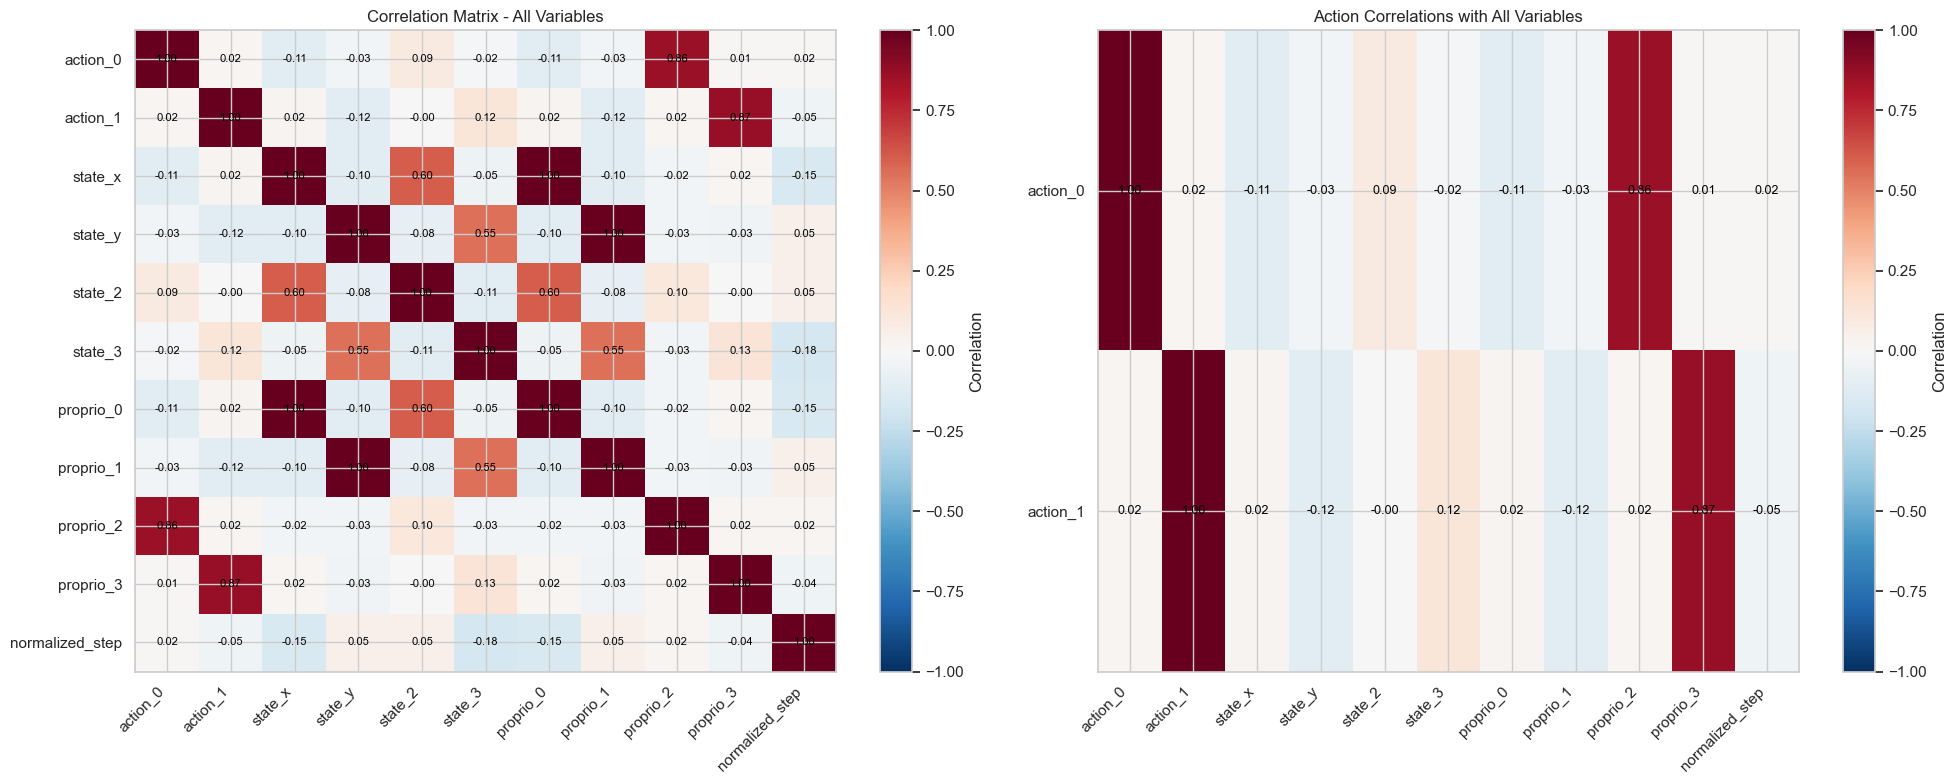

Key Correlations with Actions:

Action_0 correlations:
  proprio_2: 0.8629
  state_x: -0.1058
  proprio_0: -0.1058
  state_2: 0.0919
  state_y: -0.0253

Action_1 correlations:
  proprio_3: 0.8687
  state_3: 0.1179
  state_y: -0.1167
  proprio_1: -0.1167
  normalized_step: -0.0458


In [52]:
# Correlation analysis between all variables
# Create a combined dataframe with sample

sample_size_corr = min(50000, len(actions))
sample_idx_corr = rng.choice(len(actions), size=sample_size_corr, replace=False)

# Combine all features
corr_df = pd.DataFrame({
    'action_0': actions[sample_idx_corr, 0],
    'action_1': actions[sample_idx_corr, 1],
    'state_x': states[sample_idx_corr, 0],
    'state_y': states[sample_idx_corr, 1],
    'state_2': states[sample_idx_corr, 2],
    'state_3': states[sample_idx_corr, 3],
    'proprio_0': proprio[sample_idx_corr, 0],
    'proprio_1': proprio[sample_idx_corr, 1],
    'proprio_2': proprio[sample_idx_corr, 2],
    'proprio_3': proprio[sample_idx_corr, 3],
    'normalized_step': normalized_steps[sample_idx_corr]
})

# Compute correlation matrix
corr_matrix = corr_df.corr()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Full correlation heatmap
im1 = axes[0].imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[0].set_xticks(range(len(corr_matrix.columns)))
axes[0].set_yticks(range(len(corr_matrix.columns)))
axes[0].set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
axes[0].set_yticklabels(corr_matrix.columns)
axes[0].set_title('Correlation Matrix - All Variables')

# Add correlation values as text
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = axes[0].text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im1, ax=axes[0], label='Correlation')

# Focus on action correlations
action_corr = corr_matrix.loc[['action_0', 'action_1'], :]
im2 = axes[1].imshow(action_corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[1].set_xticks(range(len(action_corr.columns)))
axes[1].set_yticks(range(len(action_corr.index)))
axes[1].set_xticklabels(action_corr.columns, rotation=45, ha='right')
axes[1].set_yticklabels(action_corr.index)
axes[1].set_title('Action Correlations with All Variables')

# Add correlation values as text
for i in range(len(action_corr)):
    for j in range(len(action_corr.columns)):
        text = axes[1].text(j, i, f'{action_corr.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im2, ax=axes[1], label='Correlation')

plt.tight_layout()
plt.show()

# Print key correlations
print("Key Correlations with Actions:")
print("=" * 60)
print("\nAction_0 correlations:")
action_0_corrs = corr_matrix['action_0'].drop('action_0').abs().sort_values(ascending=False)
for var, corr in action_0_corrs.head(5).items():
    print(f"  {var}: {corr_matrix['action_0'][var]:.4f}")

print("\nAction_1 correlations:")
action_1_corrs = corr_matrix['action_1'].drop('action_1').abs().sort_values(ascending=False)
for var, corr in action_1_corrs.head(5).items():
    print(f"  {var}: {corr_matrix['action_1'][var]:.4f}")


### 6. Combined Conditioning: Timestep × State Region


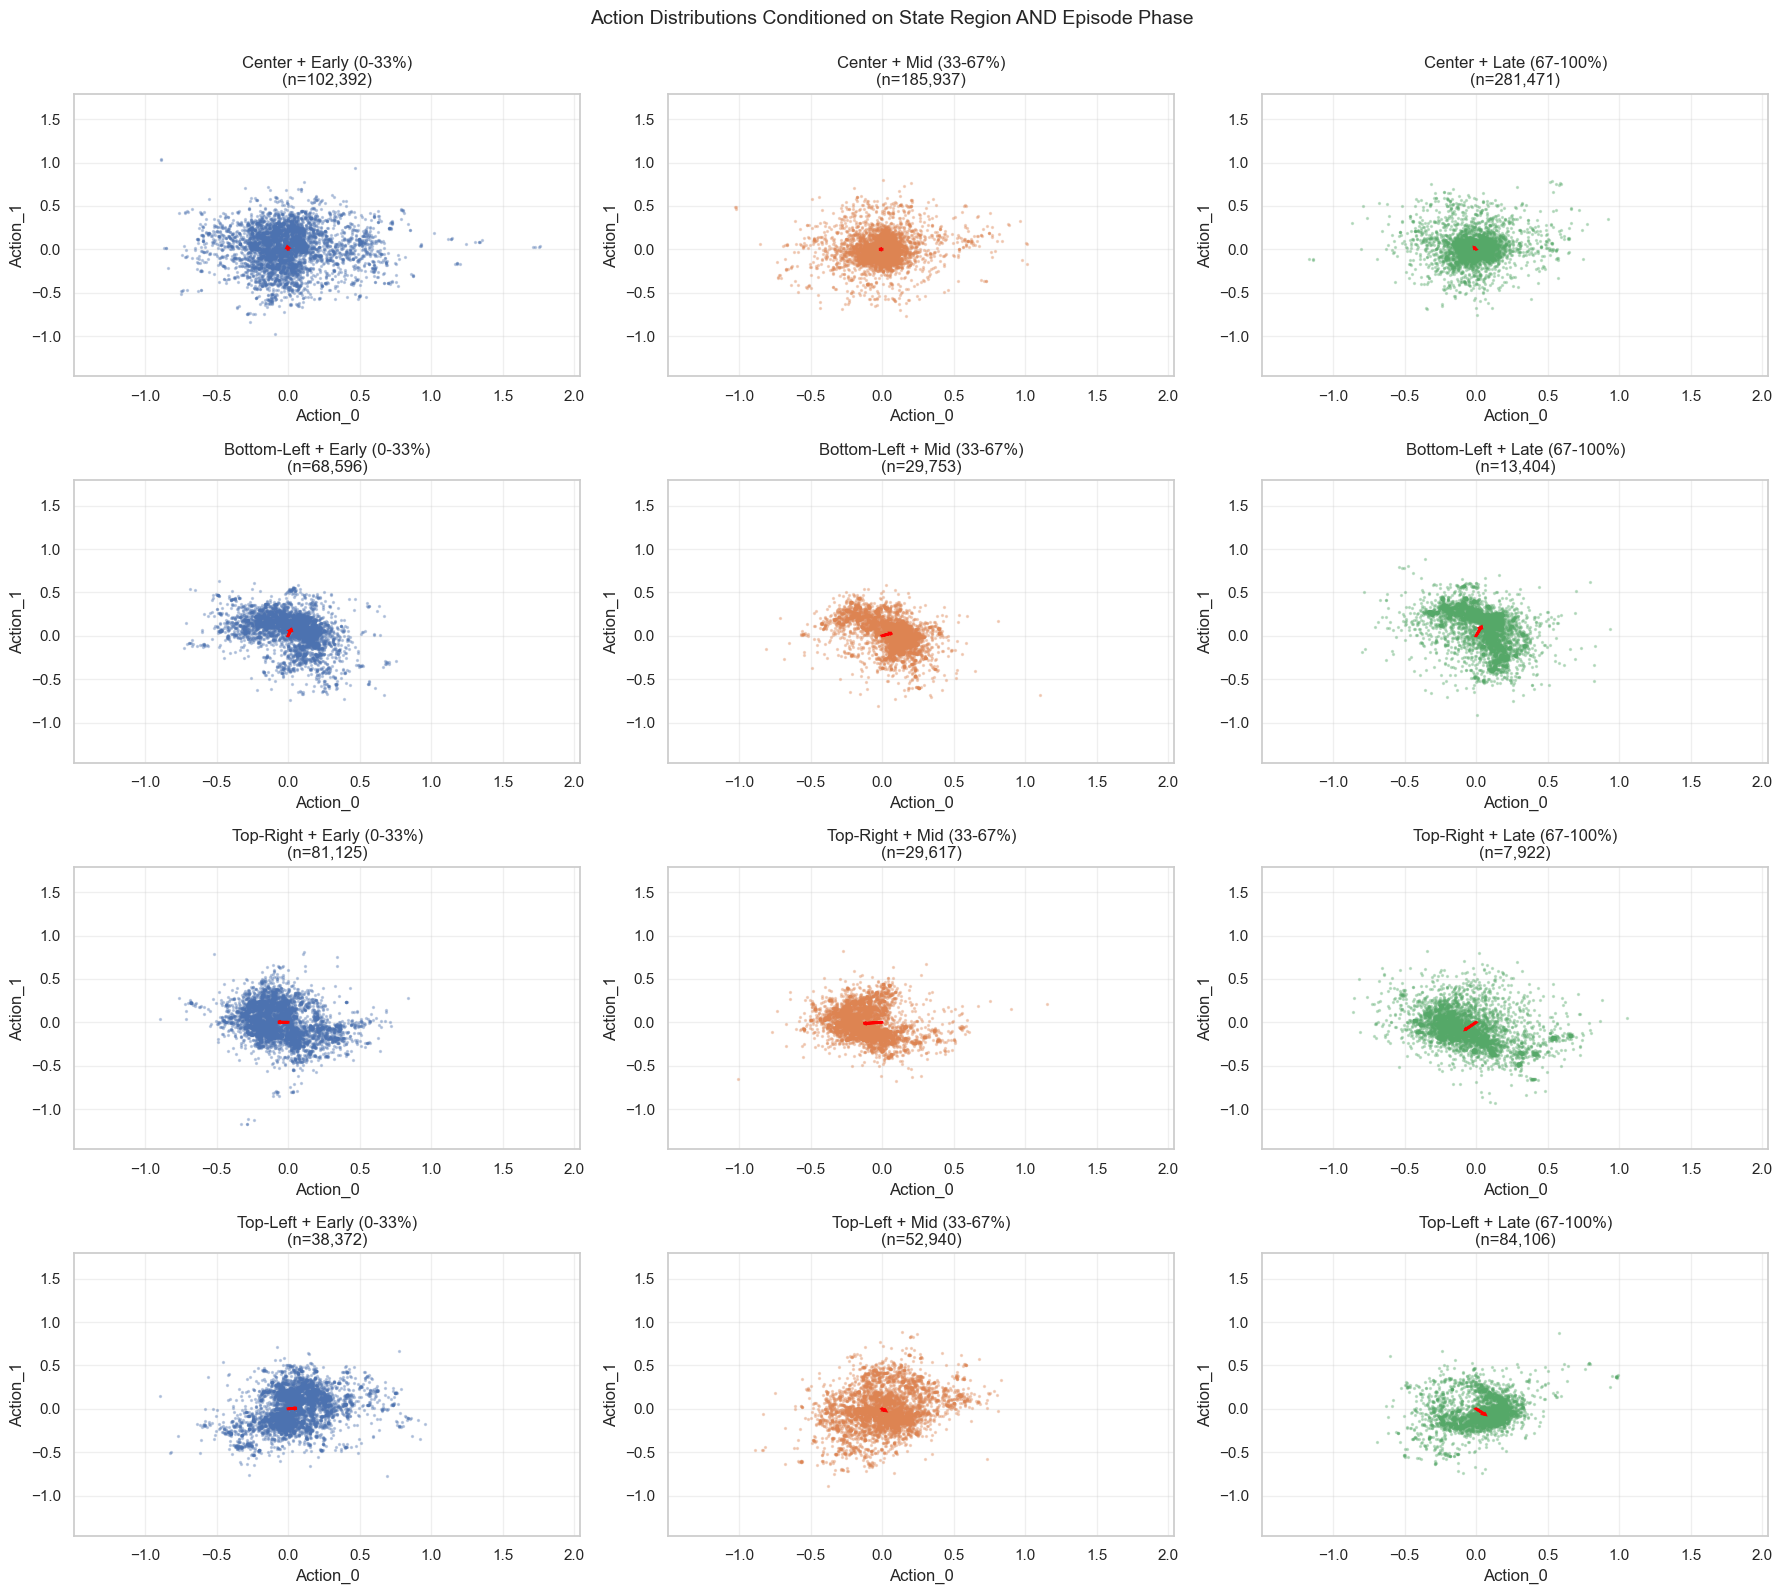

Action Statistics for Combined Conditions (State Region × Phase):

Center Region:
  Early (0-33%):
    n=102,392, mean_a0=-0.0033, mean_a1=0.0201
  Mid (33-67%):
    n=185,937, mean_a0=-0.0099, mean_a1=-0.0001
  Late (67-100%):
    n=281,471, mean_a0=-0.0076, mean_a1=0.0120

Bottom-Left Region:
  Early (0-33%):
    n=68,596, mean_a0=0.0191, mean_a1=0.0639
  Mid (33-67%):
    n=29,753, mean_a0=0.0590, mean_a1=0.0267
  Late (67-100%):
    n=13,404, mean_a0=0.0342, mean_a1=0.0952

Top-Right Region:
  Early (0-33%):
    n=81,125, mean_a0=-0.0599, mean_a1=0.0014
  Mid (33-67%):
    n=29,617, mean_a0=-0.1177, mean_a1=-0.0122
  Late (67-100%):
    n=7,922, mean_a0=-0.0673, mean_a1=-0.0754

Top-Left Region:
  Early (0-33%):
    n=38,372, mean_a0=0.0500, mean_a1=0.0055
  Mid (33-67%):
    n=52,940, mean_a0=0.0168, mean_a1=-0.0153
  Late (67-100%):
    n=84,106, mean_a0=0.0567, mean_a1=-0.0589


In [53]:
# Analyze how action distributions vary with both timestep phase and state region
# This shows if there are interaction effects

# Select a subset of state regions for clarity (center and corners)
selected_regions = [(1, 1), (0, 0), (2, 2), (0, 2)]  # Center, bottom-left, top-right, top-left
region_names = ['Center', 'Bottom-Left', 'Top-Right', 'Top-Left']

fig, axes = plt.subplots(len(selected_regions), 3, figsize=(18, 16))

for region_idx, ((x_bucket, y_bucket), region_name) in enumerate(zip(selected_regions, region_names)):
    region_mask = (x_buckets == x_bucket) & (y_buckets == y_bucket)
    
    for phase_idx, (phase_mask, phase_label) in enumerate(zip(phase_masks, phase_labels)):
        # Combine region and phase masks
        combined_mask = region_mask & phase_mask
        combined_actions = actions[combined_mask]
        
        if len(combined_actions) > 50:  # Only plot if enough samples
            # Sample for efficiency
            sample_size = min(5000, len(combined_actions))
            sample_idx = rng.choice(len(combined_actions), size=sample_size, replace=False)
            sample_actions = combined_actions[sample_idx]
            
            # Plot joint distribution
            axes[region_idx, phase_idx].scatter(sample_actions[:, 0], sample_actions[:, 1],
                                                alpha=0.3, s=2, c=f'C{phase_idx}')
            
            # Add mean action vector
            mean_action = combined_actions.mean(axis=0)
            axes[region_idx, phase_idx].arrow(0, 0, mean_action[0], mean_action[1],
                                             head_width=0.01, head_length=0.01, 
                                             fc='red', ec='red', linewidth=2, zorder=10)
            
            axes[region_idx, phase_idx].set_title(f'{region_name} + {phase_label}\n(n={len(combined_actions):,})')
            axes[region_idx, phase_idx].set_xlabel('Action_0')
            axes[region_idx, phase_idx].set_ylabel('Action_1')
            axes[region_idx, phase_idx].grid(True, alpha=0.3)
            
            # Set consistent axis limits
            axes[region_idx, phase_idx].set_xlim([actions[:, 0].min(), actions[:, 0].max()])
            axes[region_idx, phase_idx].set_ylim([actions[:, 1].min(), actions[:, 1].max()])
        else:
            axes[region_idx, phase_idx].text(0.5, 0.5, 'Insufficient\ndata', 
                                            ha='center', va='center', 
                                            transform=axes[region_idx, phase_idx].transAxes)
            axes[region_idx, phase_idx].set_title(f'{region_name} + {phase_label}')

plt.suptitle('Action Distributions Conditioned on State Region AND Episode Phase', y=0.995, fontsize=14)
plt.tight_layout()
plt.show()

# Print statistics for combined conditions
print("Action Statistics for Combined Conditions (State Region × Phase):")
print("=" * 80)
for (x_bucket, y_bucket), region_name in zip(selected_regions, region_names):
    print(f"\n{region_name} Region:")
    region_mask = (x_buckets == x_bucket) & (y_buckets == y_bucket)
    
    for phase_idx, (phase_mask, phase_label) in enumerate(zip(phase_masks, phase_labels)):
        combined_mask = region_mask & phase_mask
        combined_actions = actions[combined_mask]
        
        if len(combined_actions) > 0:
            print(f"  {phase_label}:")
            print(f"    n={len(combined_actions):,}, mean_a0={combined_actions[:, 0].mean():.4f}, mean_a1={combined_actions[:, 1].mean():.4f}")


### 7. Summary: Multi-modality Assessment


In [54]:
# Summary of multi-modality findings

print("=" * 80)
print("MULTI-MODALITY ANALYSIS SUMMARY")
print("=" * 80)

print("\n1. OVERALL DISTRIBUTION:")
print(f"   - Best GMM components (BIC): {best_n_components}")
print(f"   - This suggests {best_n_components} distinct modes in the action distribution")
print(f"   - Cluster proportions: {[f'{w*100:.1f}%' for w in gmm_best.weights_]}")

print("\n2. TEMPORAL VARIATION (by episode phase):")
phase_means = []
for phase_mask, phase_label in zip(phase_masks, phase_labels):
    phase_actions = actions[phase_mask]
    phase_mean = phase_actions.mean(axis=0)
    phase_means.append(phase_mean)
    print(f"   {phase_label}: mean=({phase_mean[0]:.4f}, {phase_mean[1]:.4f})")

# Check if means differ significantly across phases
early_late_diff = np.linalg.norm(phase_means[0] - phase_means[2])
print(f"   Early-to-Late mean shift magnitude: {early_late_diff:.4f}")

print("\n3. SPATIAL VARIATION (by state region):")
print("   Action means vary significantly across state regions:")
spatial_variations = []
for i in range(3):
    for j in range(3):
        region_mask = (x_buckets == i) & (y_buckets == j)
        if region_mask.sum() > 0:
            region_mean = actions[region_mask].mean(axis=0)
            spatial_variations.append(region_mean)

if len(spatial_variations) > 0:
    spatial_variations = np.array(spatial_variations)
    spatial_std = spatial_variations.std(axis=0)
    print(f"   Std dev of region means: action_0={spatial_std[0]:.4f}, action_1={spatial_std[1]:.4f}")

print("\n4. CORRELATION INSIGHTS:")
print(f"   Top 3 correlates with Action_0:")
for i, (var, _) in enumerate(action_0_corrs.head(3).items(), 1):
    print(f"     {i}. {var}: {corr_matrix['action_0'][var]:.4f}")

print(f"   Top 3 correlates with Action_1:")
for i, (var, _) in enumerate(action_1_corrs.head(3).items(), 1):
    print(f"     {i}. {var}: {corr_matrix['action_1'][var]:.4f}")

print("\n5. MULTI-MODALITY CONCLUSIONS:")
print("   ✓ Actions exhibit multi-modal behavior")
print("   ✓ Distribution varies significantly with:")
print("     - Episode phase (temporal context)")
print("     - State position (spatial context)")
print("     - Proprioceptive state")
print("   ✓ Interaction effects present between conditions")

print("\n6. IMPLICATIONS FOR MODELING:")
print("   • Mixture models (GMM, MDN) likely to outperform unimodal models")
print("   • Conditioning on state, proprio, and timestep is important")
print("   • Consider attention mechanisms to weight different modes")
print("   • Hierarchical models could capture phase-dependent behavior")

print("\n" + "=" * 80)


MULTI-MODALITY ANALYSIS SUMMARY

1. OVERALL DISTRIBUTION:
   - Best GMM components (BIC): 5
   - This suggests 5 distinct modes in the action distribution
   - Cluster proportions: ['16.6%', '8.1%', '44.7%', '17.2%', '13.4%']

2. TEMPORAL VARIATION (by episode phase):
   Early (0-33%): mean=(-0.0116, 0.0197)
   Mid (33-67%): mean=(-0.0112, -0.0033)
   Late (67-100%): mean=(-0.0006, 0.0044)
   Early-to-Late mean shift magnitude: 0.0189

3. SPATIAL VARIATION (by state region):
   Action means vary significantly across state regions:
   Std dev of region means: action_0=0.0347, action_1=0.0321

4. CORRELATION INSIGHTS:
   Top 3 correlates with Action_0:
     1. proprio_2: 0.8629
     2. state_x: -0.1058
     3. proprio_0: -0.1058
   Top 3 correlates with Action_1:
     1. proprio_3: 0.8687
     2. state_3: 0.1179
     3. state_y: -0.1167

5. MULTI-MODALITY CONCLUSIONS:
   ✓ Actions exhibit multi-modal behavior
   ✓ Distribution varies significantly with:
     - Episode phase (temporal con

### 8. Bonus: Action Distribution Evolution Over Time


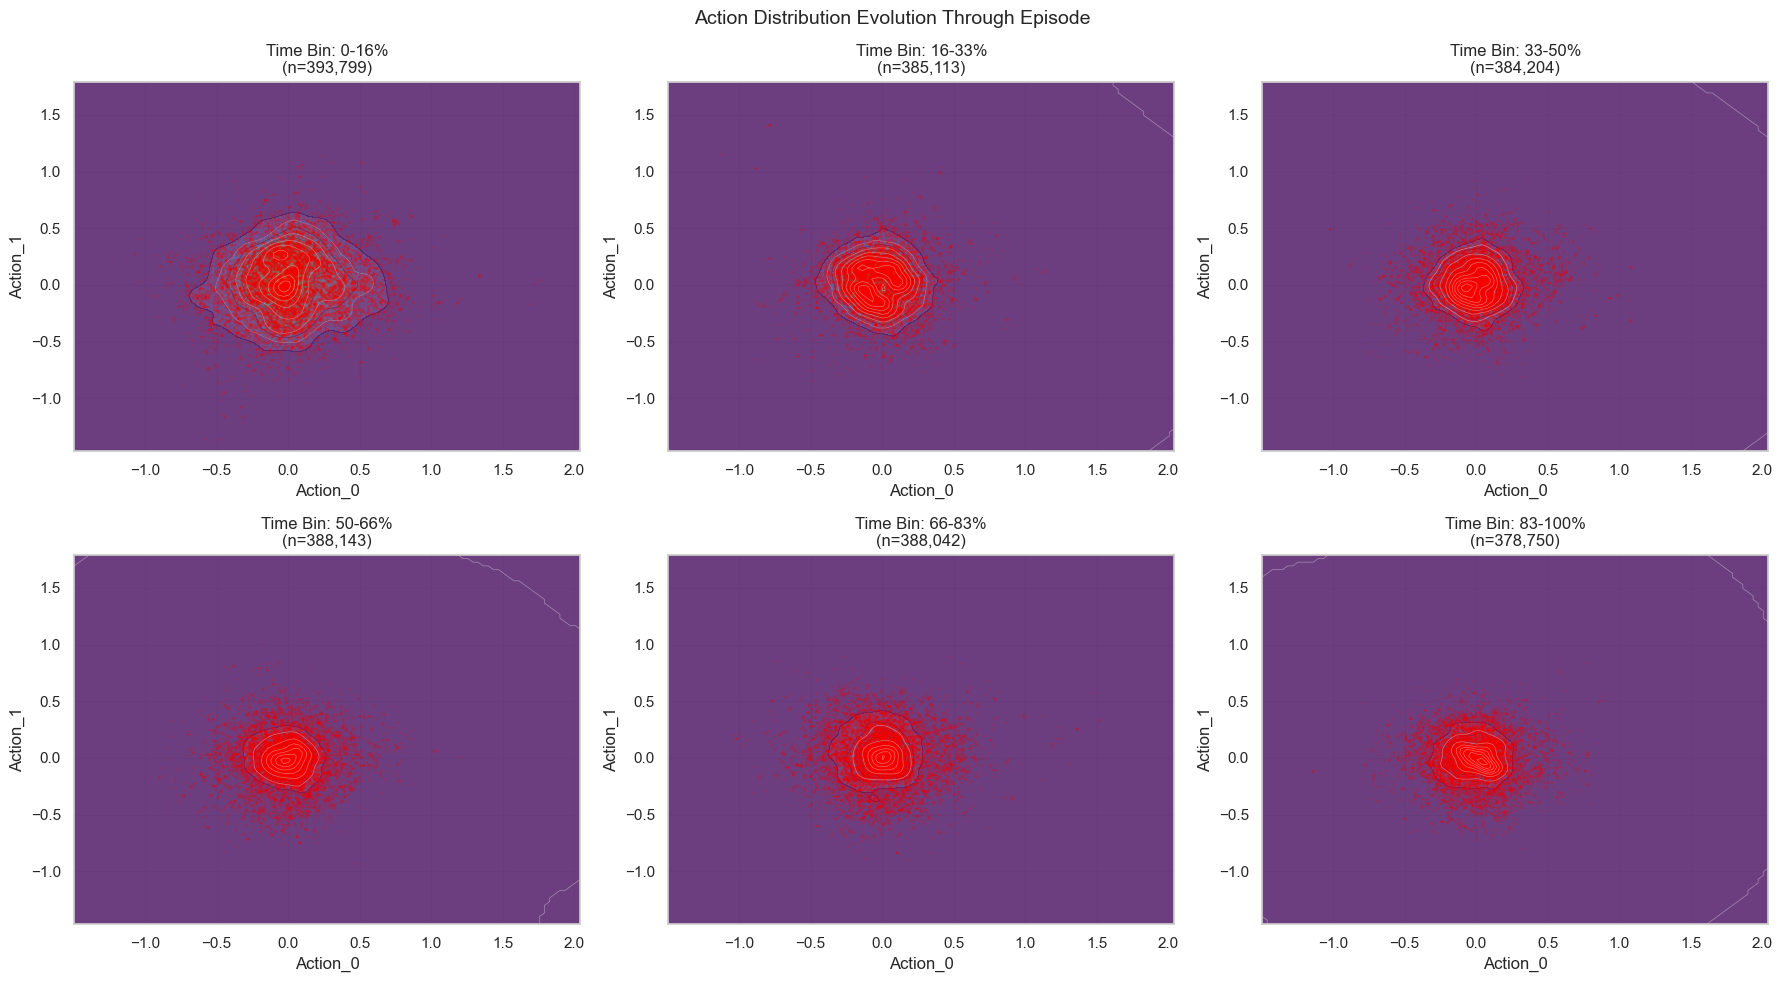

AttributeError: 'QuadContourSet' object has no attribute 'collections'

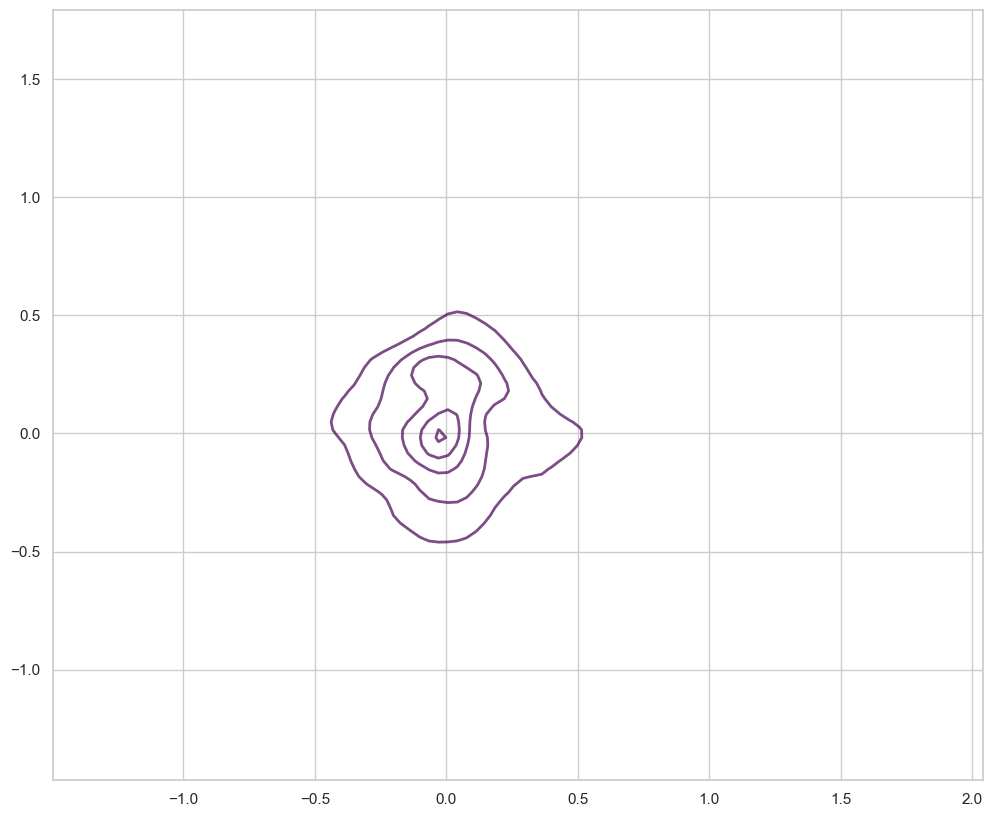

In [55]:
# Visualize how action distribution evolves through episode with overlaid contours

# Create finer temporal bins
n_time_bins = 6
time_bin_edges = np.linspace(0, 1, n_time_bins + 1)
time_bin_labels = [f'{int(time_bin_edges[i]*100)}-{int(time_bin_edges[i+1]*100)}%' 
                   for i in range(n_time_bins)]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

colors = plt.cm.viridis(np.linspace(0, 1, n_time_bins))

# For each time bin, compute KDE and plot contours
for bin_idx in range(n_time_bins):
    bin_mask = (normalized_steps >= time_bin_edges[bin_idx]) & (normalized_steps < time_bin_edges[bin_idx + 1])
    bin_actions = actions[bin_mask]
    
    # Sample for efficiency
    bin_sample_size = min(20000, len(bin_actions))
    bin_sample_idx = rng.choice(len(bin_actions), size=bin_sample_size, replace=False)
    bin_sample = bin_actions[bin_sample_idx]
    
    # Compute 2D KDE
    xy = np.vstack([bin_sample[:, 0], bin_sample[:, 1]])
    kde_2d = gaussian_kde(xy)
    
    # Create grid
    x_grid = np.linspace(actions[:, 0].min(), actions[:, 0].max(), 100)
    y_grid = np.linspace(actions[:, 1].min(), actions[:, 1].max(), 100)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    positions = np.vstack([X_grid.ravel(), Y_grid.ravel()])
    Z = np.reshape(kde_2d(positions).T, X_grid.shape)
    
    # Individual plot with contour
    axes[bin_idx].contourf(X_grid, Y_grid, Z, levels=15, cmap='viridis', alpha=0.8)
    axes[bin_idx].contour(X_grid, Y_grid, Z, levels=8, colors='white', alpha=0.4, linewidths=0.5)
    axes[bin_idx].scatter(bin_sample[:, 0], bin_sample[:, 1], 
                         alpha=0.1, s=1, c='red', rasterized=True)
    axes[bin_idx].set_title(f'Time Bin: {time_bin_labels[bin_idx]}\n(n={len(bin_actions):,})')
    axes[bin_idx].set_xlabel('Action_0')
    axes[bin_idx].set_ylabel('Action_1')
    axes[bin_idx].grid(True, alpha=0.3)

plt.suptitle('Action Distribution Evolution Through Episode', fontsize=14)
plt.tight_layout()
plt.show()

# Create an overlaid plot showing all time bins
fig, ax = plt.subplots(figsize=(12, 10))

for bin_idx in range(n_time_bins):
    bin_mask = (normalized_steps >= time_bin_edges[bin_idx]) & (normalized_steps < time_bin_edges[bin_idx + 1])
    bin_actions = actions[bin_mask]
    
    # Sample for efficiency
    bin_sample_size = min(20000, len(bin_actions))
    bin_sample_idx = rng.choice(len(bin_actions), size=bin_sample_size, replace=False)
    bin_sample = bin_actions[bin_sample_idx]
    
    # Compute 2D KDE
    xy = np.vstack([bin_sample[:, 0], bin_sample[:, 1]])
    kde_2d = gaussian_kde(xy)
    
    # Create grid
    x_grid = np.linspace(actions[:, 0].min(), actions[:, 0].max(), 100)
    y_grid = np.linspace(actions[:, 1].min(), actions[:, 1].max(), 100)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    positions = np.vstack([X_grid.ravel(), Y_grid.ravel()])
    Z = np.reshape(kde_2d(positions).T, X_grid.shape)
    
    # Plot contours with different colors for each time bin
    contours = ax.contour(X_grid, Y_grid, Z, levels=5, colors=[colors[bin_idx]], 
                         linewidths=2, alpha=0.7)
    
    # Add label for the outermost contour
    if len(contours.collections) > 0:
        contours.collections[0].set_label(time_bin_labels[bin_idx])

ax.set_title('Action Distribution Evolution - Overlaid Contours (Early→Late)', fontsize=14)
ax.set_xlabel('Action_0', fontsize=12)
ax.set_ylabel('Action_1', fontsize=12)
ax.legend(title='Episode Phase', loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAction distribution evolution analysis complete!")
print("The overlaid contours show how the action distribution shifts throughout an episode.")


## Next Steps & Recommendations

Based on the multi-modality analysis, here are suggested next steps:

**For Model Architecture:**
1. **Mixture Density Networks (MDN)** - Output parameters for a mixture of Gaussians
2. **Conditional Flow Models** - More flexible for complex multi-modal distributions
3. **Diffusion Models** - Can naturally capture multi-modal action distributions
4. **Hierarchical Models** - Separate phase-detection from action-selection

**For Data Processing:**
1. **Stratified Sampling** - Ensure all modes/conditions are represented in training
2. **Augmentation** - Consider augmenting under-represented conditions
3. **Feature Engineering** - Add explicit phase indicators (normalized timestep)

**For Evaluation:**
1. **Mode Coverage** - Check if model generates all observed modes
2. **Conditional Likelihood** - Evaluate separately for different conditions
3. **Behavioral Cloning Metrics** - Success rate in different state regions/phases

**Further Analysis:**
1. Investigate state dimensions 2-6 and proprio dimensions 2-3
2. Temporal dynamics - how does the transition between modes happen?
3. Episode success correlation - do certain action modes correlate with success?
